Get the activation distribution and the number of neurones inactivated

estimated time: 3min

In [1]:
#IPython extension to reload modules before executing user code.
#'autoreload' reloads modules automatically before entering the execution of code typed at the IPython prompt.
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import gpustat

#select the best free GPU on the nvidia card
stats = gpustat.GPUStatCollection.new_query()
ids = map(lambda gpu: int(gpu.entry['index']), stats)
ratios = map(lambda gpu: float(gpu.entry['memory.used'])/float(gpu.entry['memory.total']), stats)
bestGPU = min(zip(ids, ratios), key=lambda x: x[1])[0]
bestGPU = 2

print("setGPU: Setting GPU to: {}".format(bestGPU))
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = str(bestGPU)

'''
#set memory usage to 0.5
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))'''

setGPU: Setting GPU to: 2


'\n#set memory usage to 0.5\nfrom keras.backend.tensorflow_backend import set_session\nimport tensorflow as tf\nconfig = tf.ConfigProto()\nconfig.gpu_options.per_process_gpu_memory_fraction = 0.5\nset_session(tf.Session(config=config))'

In [3]:
#!pip install -q sklearn
import collections
import numpy as np, numpy
from keract import get_activations, display_activations
import keras
from keras import backend as K
from keras import optimizers, regularizers
from keras.callbacks import LearningRateScheduler
from keras.datasets import cifar10, cifar100 # we can use also cifar100
from keras.layers import Input, BatchNormalization, AveragePooling2D, ZeroPadding2D, LeakyReLU, GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, Model
from keras.regularizers import l2
from keras.utils import plot_model, to_categorical
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy
import sklearn
import sklearn.metrics
import sys
#sys.executable
#sys.path
import time
from IPython.display import SVG

from layca_optimizers import SGD

Using TensorFlow backend.


In [4]:
def normalize(x, mean, std):
    # This function normalizes inputs for zero mean and unit variance to speed up learning.
    
    # In case std = 0, we add eps = 1e-7
    eps = K.epsilon()
    x = (x-mean)/(std+eps)
    return x
  
def import_cifar(dataset):
    if dataset == 10:
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    elif dataset == 100:
        (x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

    # By default, they are uint8 but we need them float to normalize them
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    # Calculating the mean and standard deviation of the training data
    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    
    # Normalizing 
    x_train = normalize(x_train, mean, std)
    x_test = normalize(x_test, mean, std)

    y_train = to_categorical(y_train, num_classes=dataset)
    y_test = to_categorical(y_test,  num_classes=dataset)
    
    return (x_train, y_train), (x_test, y_test)

In [5]:
# LOAD DATABase
num_classes = 10
(x_train, y_train), (x_test, y_test) = import_cifar(num_classes)

In [6]:
# Architecture taken from https://github.com/geifmany/cifar-vgg
# Weight decay and Dropout have been removed
# BatchNormalization before activations
def VGG16_Vanilla_beta(input_shape, num_classes):
    model = Sequential([
        #0
        Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #3
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #7
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #10
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #14
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #17
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #20
        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #24
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #27
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #30
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        #34
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #37
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #40
        Conv2D(512, (3, 3), padding='same'),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        #45
        Dense(512),
        BatchNormalization(scale=False, center=False),
        Activation('relu'),
        #48
        Dense(num_classes),
        BatchNormalization(scale=False, center=False),
        Activation('softmax')])
    return model

In [7]:
List_of_Pré_Activations = ['conv2d_1/BiasAdd:0','conv2d_2/BiasAdd:0','max_pooling2d_1/MaxPool:0','conv2d_3/BiasAdd:0', 'conv2d_4/BiasAdd:0','max_pooling2d_2/MaxPool:0','conv2d_5/BiasAdd:0', 'conv2d_6/BiasAdd:0','conv2d_7/BiasAdd:0', 'max_pooling2d_3/MaxPool:0','conv2d_8/BiasAdd:0', 'conv2d_9/BiasAdd:0','conv2d_10/BiasAdd:0', 'max_pooling2d_4/MaxPool:0','conv2d_11/BiasAdd:0', 'conv2d_12/BiasAdd:0','conv2d_13/BiasAdd:0', 'max_pooling2d_5/MaxPool:0','dense_1/BiasAdd:0', 'dense_2/BiasAdd:0']
List_of_Post_Activations = [    'activation_1/Relu:0','activation_2/Relu:0',    'activation_3/Relu:0','activation_4/Relu:0',    'activation_5/Relu:0','activation_6/Relu:0',    'activation_7/Relu:0','activation_8/Relu:0',    'activation_9/Relu:0','activation_10/Relu:0',    'activation_11/Relu:0','activation_12/Relu:0',    'activation_13/Relu:0','activation_14/Relu:0',    'activation_15/Softmax:0']

In [8]:
nombreDImagesDActivation = 2000
plt.rcParams.update({'font.size': 22})

Nombre de neurones inactivés par couche = nombre d'occurence valant 0 (car moyenne des activations sur 2000 images)

In [9]:
def RUN(IM, modelename, doss):
    print('modelename: '+str(modelename))
    i = 0
    for layer in List_of_Post_Activations:
        i = i +1
        numNeurons = numpy.size(IM[layer][0])
        print('number of neurons for the layer {}: {}'.format(i, numNeurons))
        
        if i < 14:
            histoReshape =IM[layer][:,:,:,:].reshape((nombreDImagesDActivation, numNeurons))
            histoMean = np.mean(histoReshape, axis=0) # ok, nombre d'activation = nombre de neurones (numNeurons)
        else:
            histoMean = np.mean(IM[layer][:,:], axis=0)
        
        # plot:
        fig = plt.figure(figsize=(10, 5))
        #plt.ylim(top=)
        plt.grid()
        #plt.xlim(right=3)
        plt.hist(histoMean,bins='auto')
        #plt.legend(['', ''])
        #.xlabel('value')
        #plt.ylabel('occurence')
        #if i < 14:
        #    plt.title('mean post activation histograme modelename {} couche conv{}'.format(modelename, i))
        #else:
        #    plt.title('mean post activation histograme modelename {} couche dense{}'.format(modelename, i))
        plt.show()
        fig.savefig('figures/Activations2/{}Distribution_{}_c{}.png'.format(doss, modelename, i), dpi=100)

modelename: initial
number of neurons for the layer 1: 65536


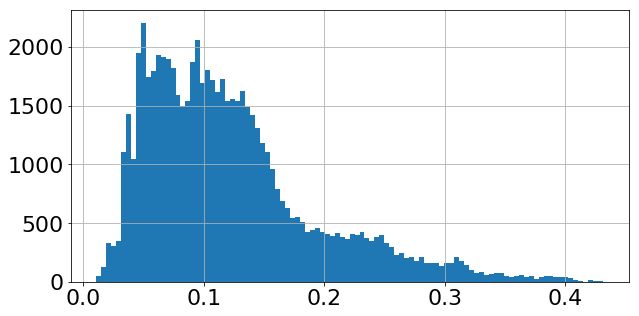

number of neurons for the layer 2: 65536


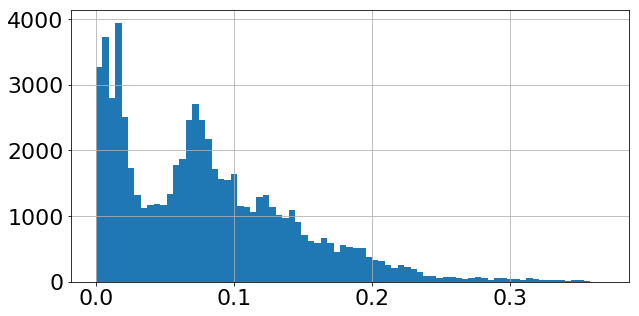

number of neurons for the layer 3: 32768


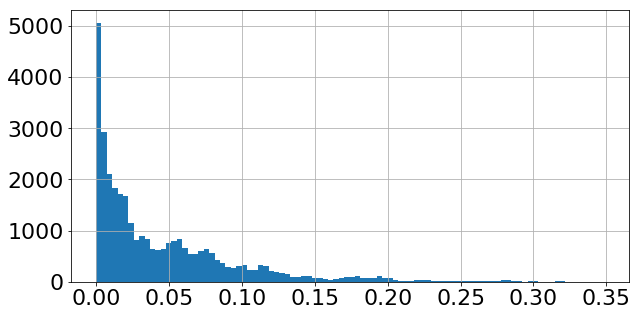

number of neurons for the layer 4: 32768


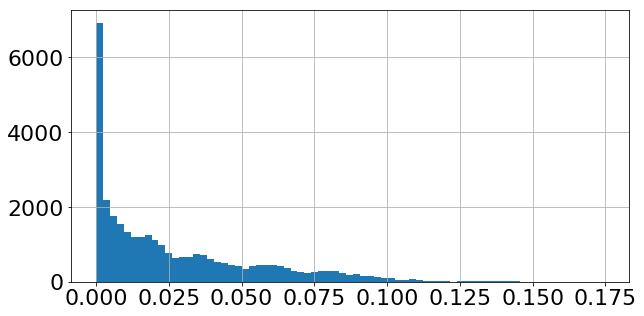

number of neurons for the layer 5: 16384


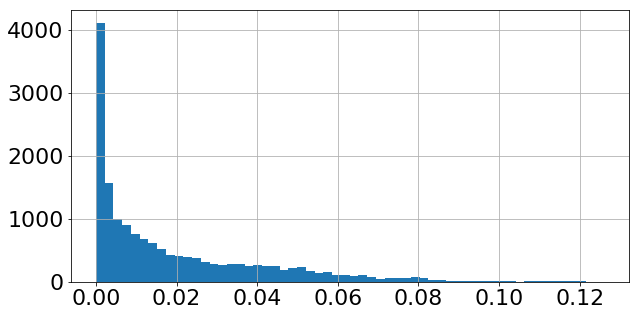

number of neurons for the layer 6: 16384


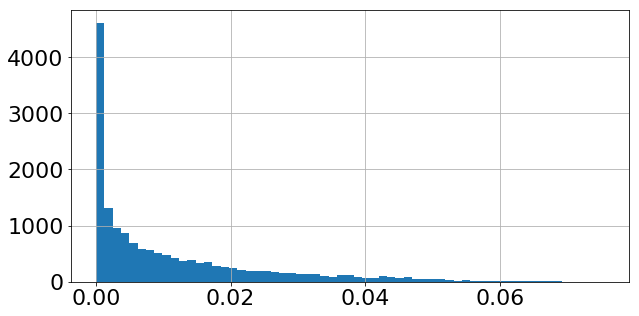

number of neurons for the layer 7: 16384


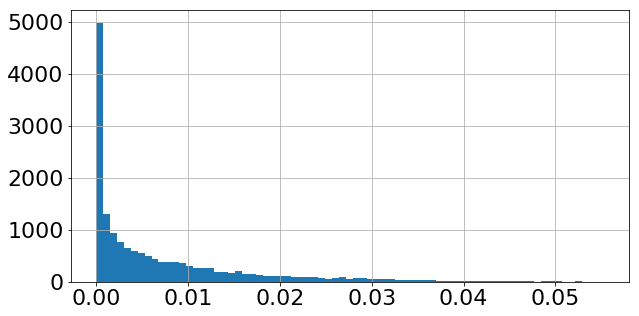

number of neurons for the layer 8: 8192


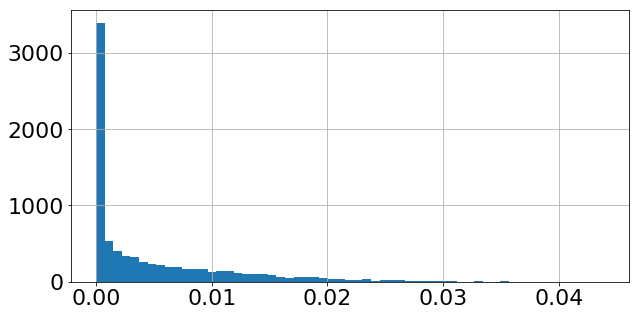

number of neurons for the layer 9: 8192


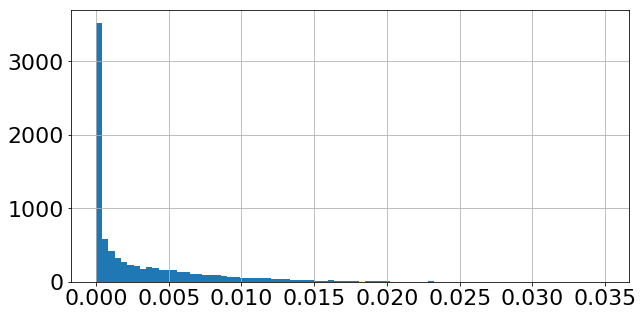

number of neurons for the layer 10: 8192


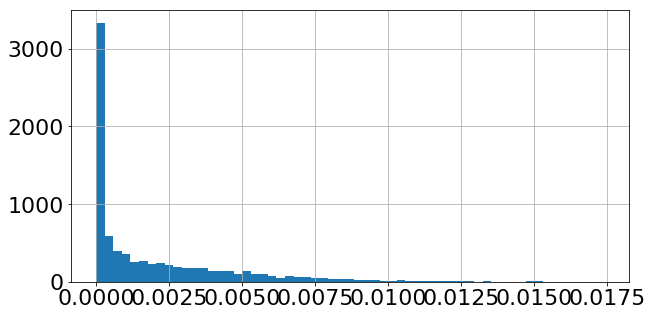

number of neurons for the layer 11: 2048


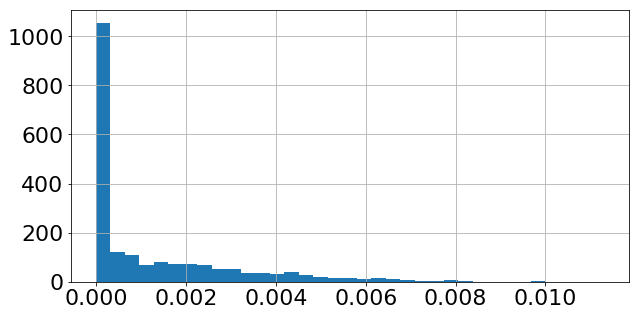

number of neurons for the layer 12: 2048


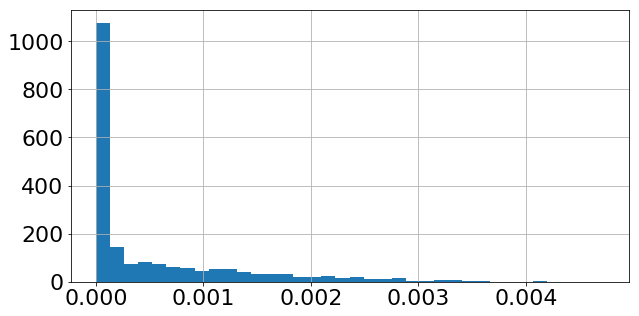

number of neurons for the layer 13: 2048


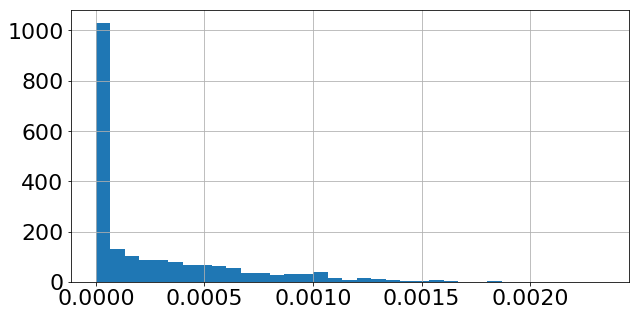

number of neurons for the layer 14: 512


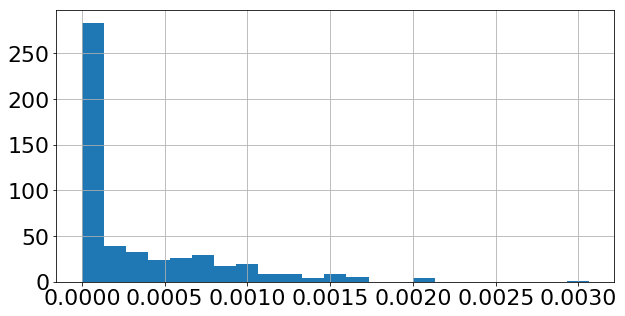

number of neurons for the layer 15: 10


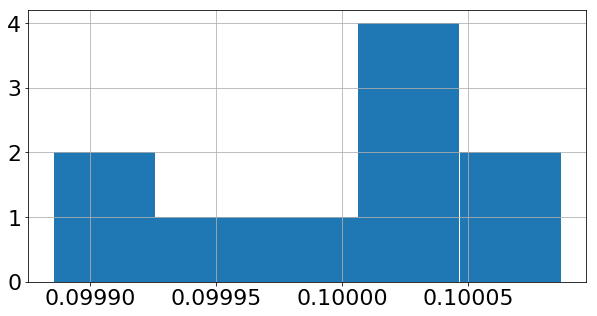

In [10]:
# LOAD the model and get the activations
doss = 'Initial/'
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/initial/weights-initial.hdf5'.format(modelename) #final / initial ! attention au nom de sauvegarde !
modelename = 'initial'
model = VGG16_Vanilla_beta(input_shape=(32,32,3), num_classes=10)
model.load_weights('{}'.format(model_name))
sgd = optimizers.SGD(lr=0.002, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
# On regarde l'activation des pairs de neurones pour un echantillon test pris au hasard
Echantillon = []
choix = np.random.choice(x_test.shape[0], nombreDImagesDActivation)
Echantillon = x_train[choix, :, : , :]
IM = get_activations(model, Echantillon)# on affiche les noms des differentes couches
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_layca_0
number of neurons for the layer 1: 65536


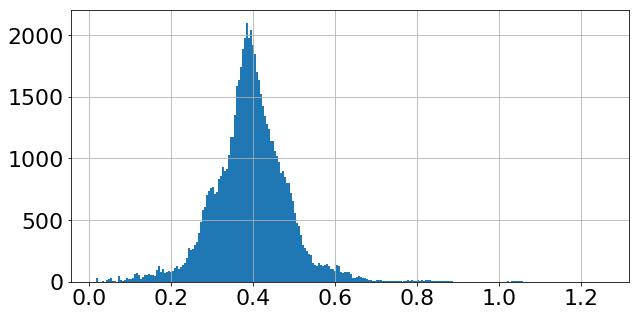

number of neurons for the layer 2: 65536


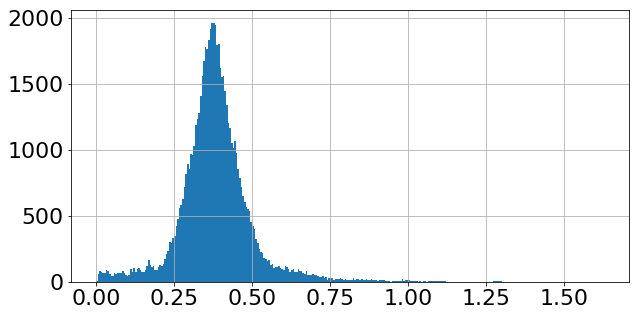

number of neurons for the layer 3: 32768


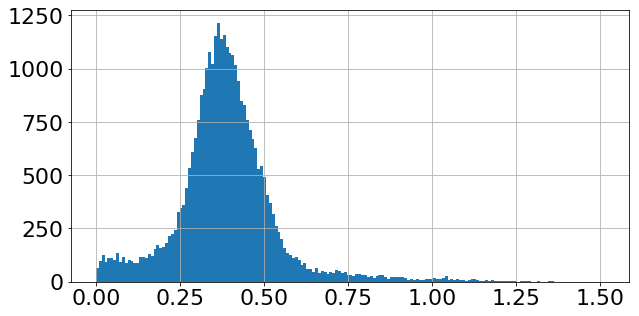

number of neurons for the layer 4: 32768


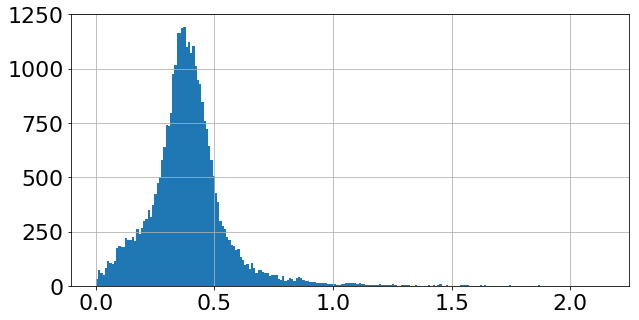

number of neurons for the layer 5: 16384


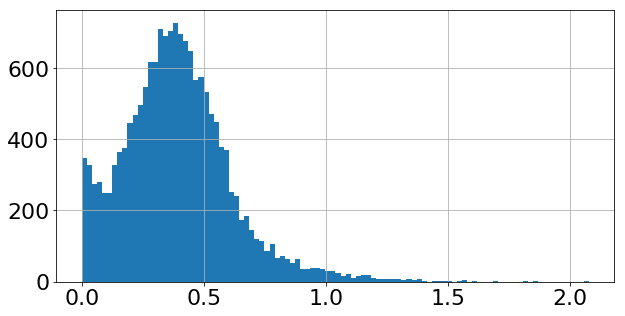

number of neurons for the layer 6: 16384


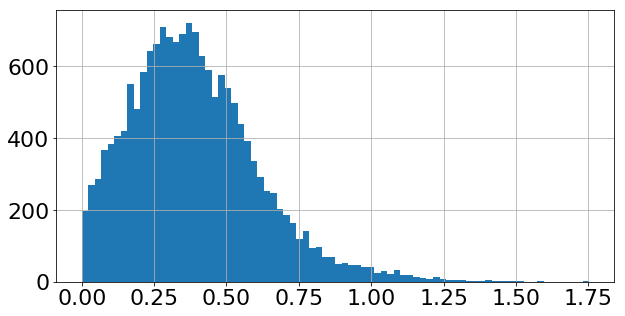

number of neurons for the layer 7: 16384


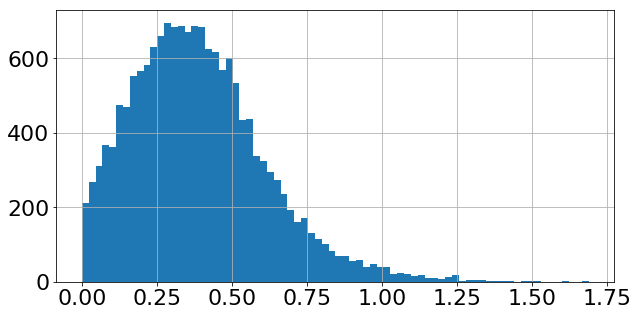

number of neurons for the layer 8: 8192


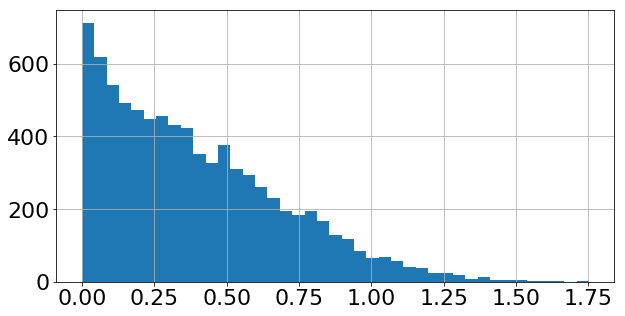

number of neurons for the layer 9: 8192


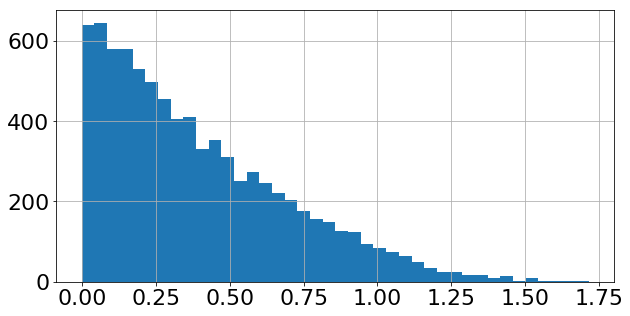

number of neurons for the layer 10: 8192


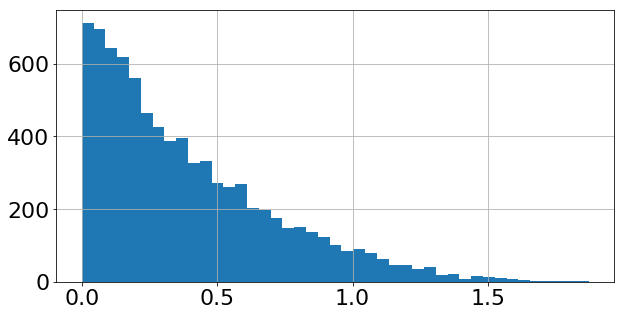

number of neurons for the layer 11: 2048


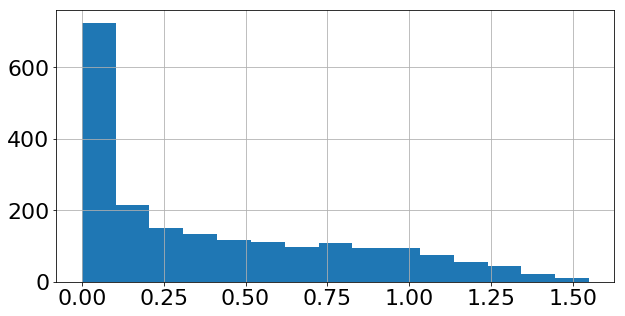

number of neurons for the layer 12: 2048


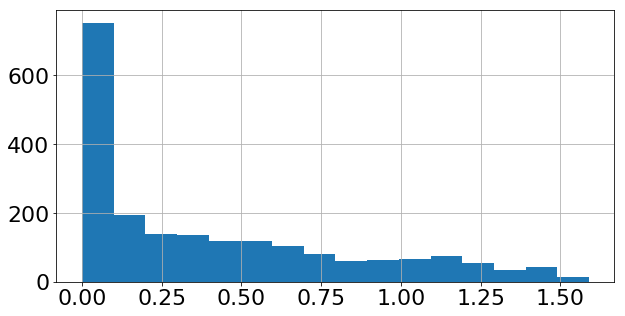

number of neurons for the layer 13: 2048


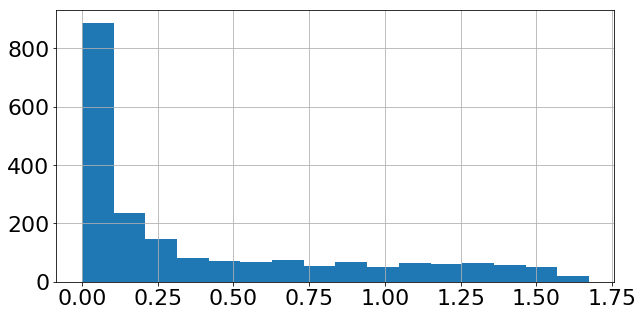

number of neurons for the layer 14: 512


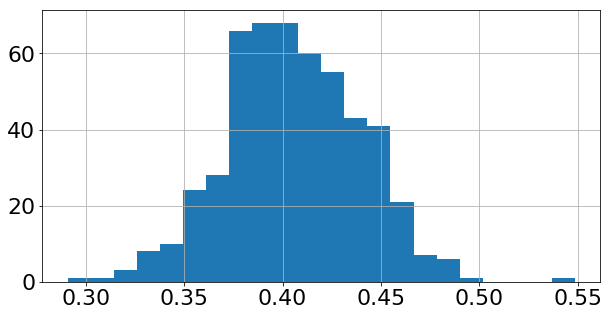

number of neurons for the layer 15: 10


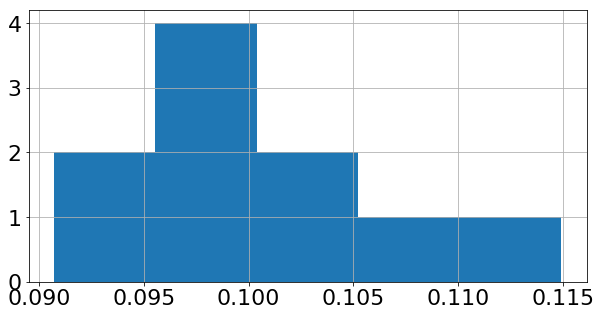

In [11]:
doss = 'Layca 0/'
modelename = 'vgg16_layca_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_layca_1
number of neurons for the layer 1: 65536


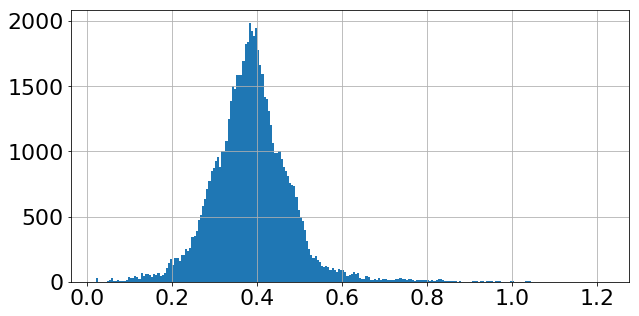

number of neurons for the layer 2: 65536


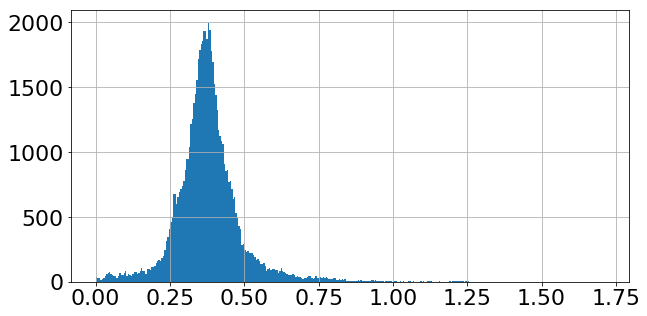

number of neurons for the layer 3: 32768


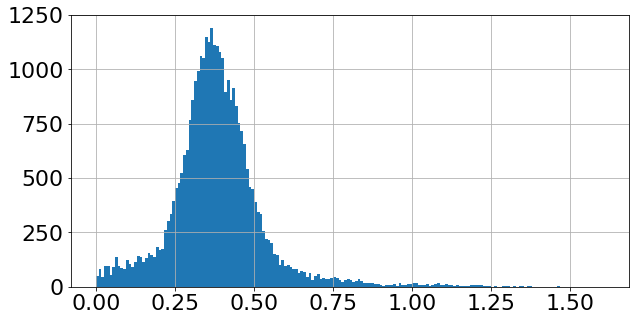

number of neurons for the layer 4: 32768


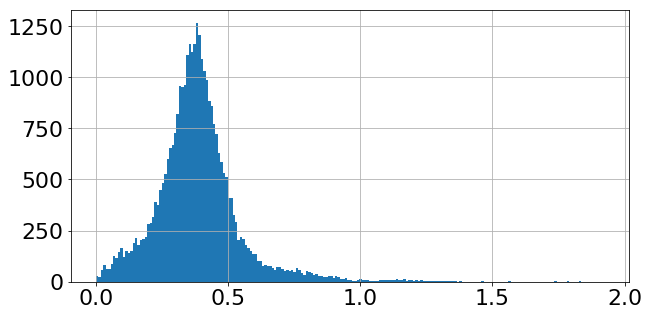

number of neurons for the layer 5: 16384


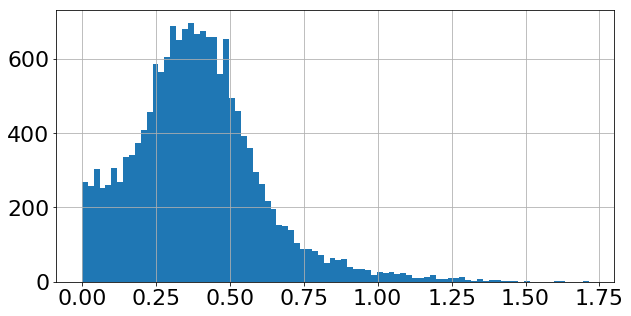

number of neurons for the layer 6: 16384


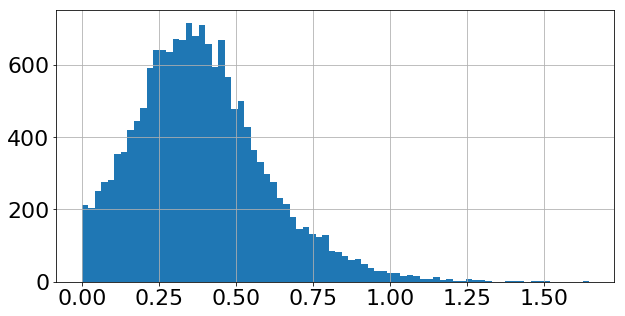

number of neurons for the layer 7: 16384


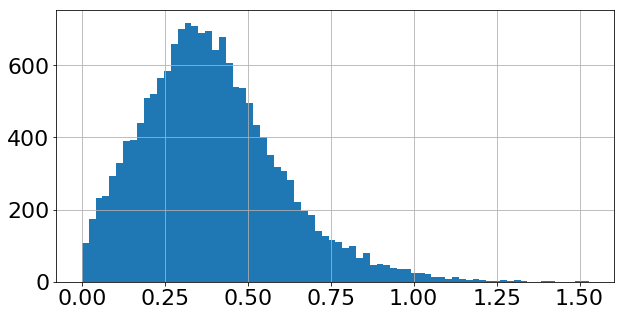

number of neurons for the layer 8: 8192


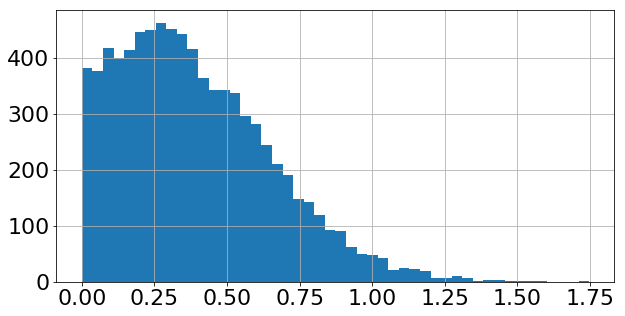

number of neurons for the layer 9: 8192


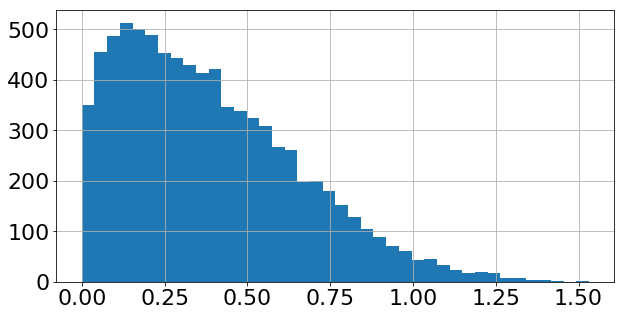

number of neurons for the layer 10: 8192


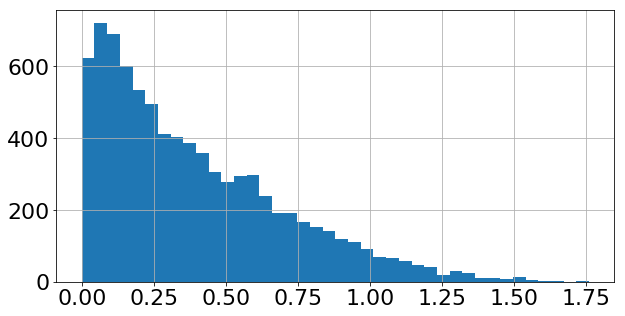

number of neurons for the layer 11: 2048


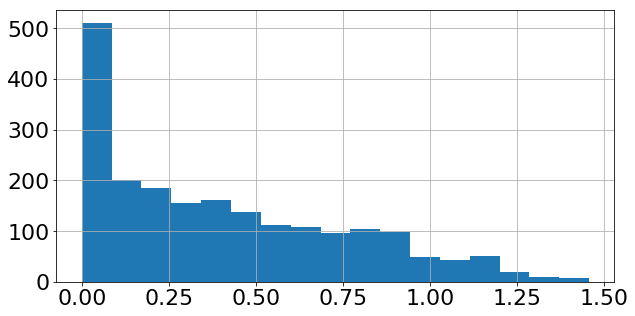

number of neurons for the layer 12: 2048


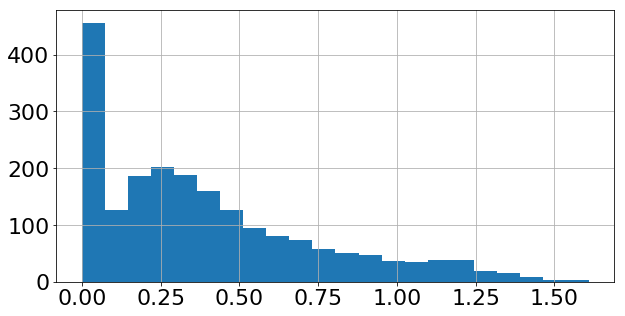

number of neurons for the layer 13: 2048


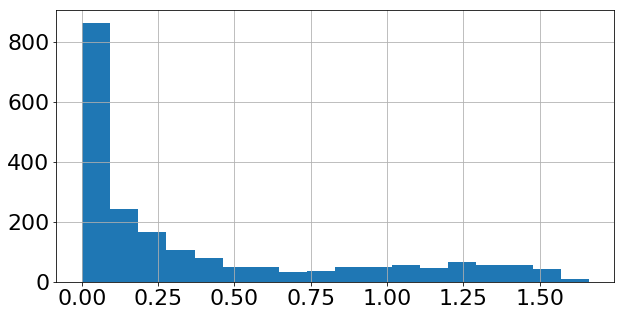

number of neurons for the layer 14: 512


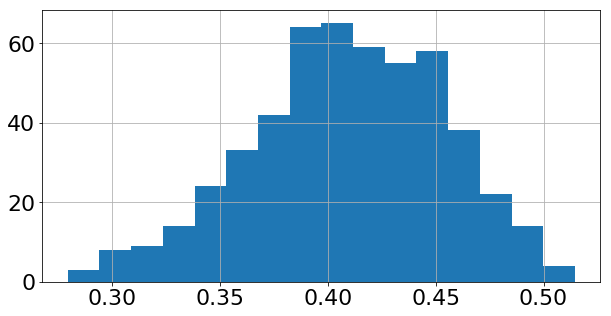

number of neurons for the layer 15: 10


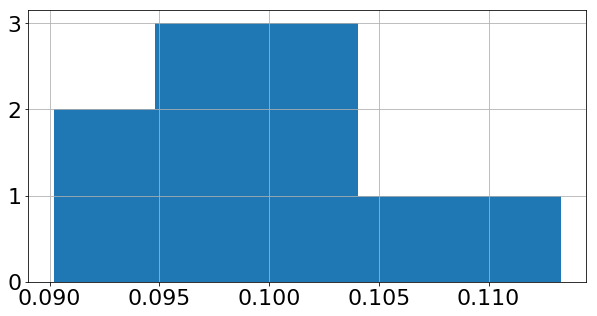

In [12]:
doss = 'Layca 1/'
modelename = 'vgg16_layca_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_layca_2
number of neurons for the layer 1: 65536


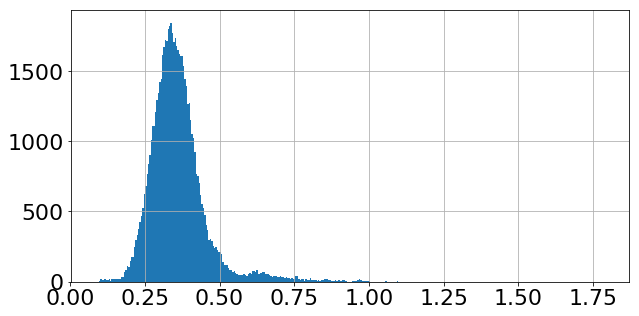

number of neurons for the layer 2: 65536


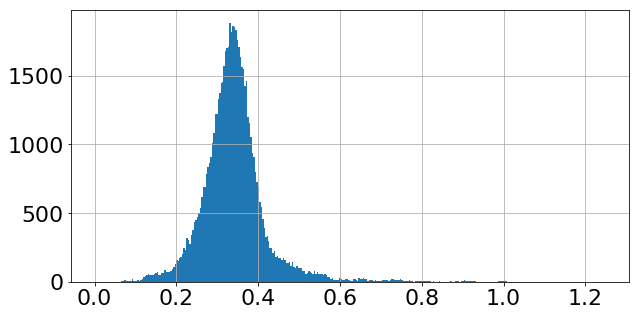

number of neurons for the layer 3: 32768


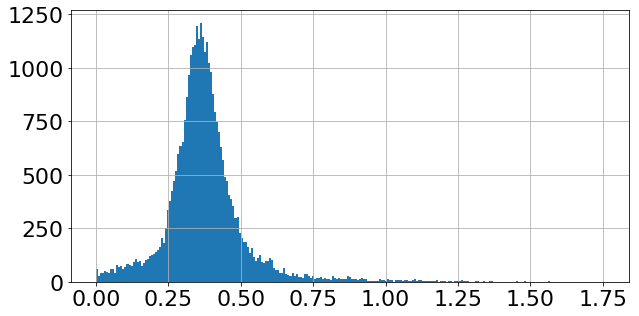

number of neurons for the layer 4: 32768


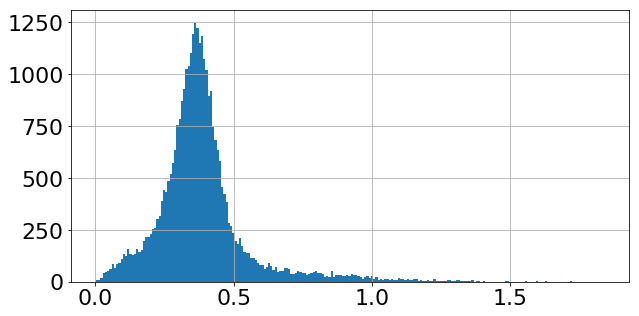

number of neurons for the layer 5: 16384


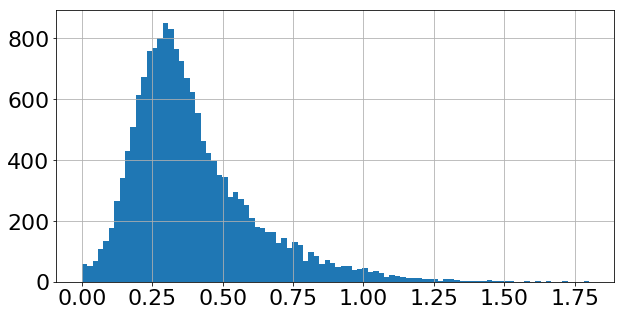

number of neurons for the layer 6: 16384


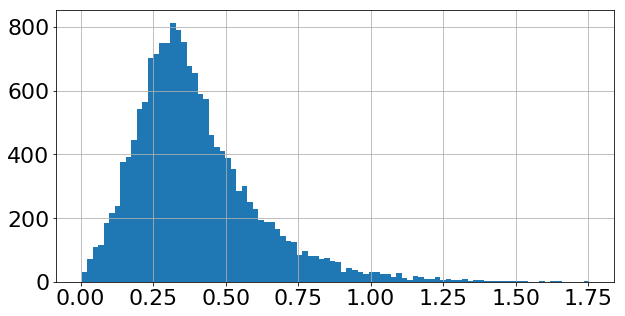

number of neurons for the layer 7: 16384


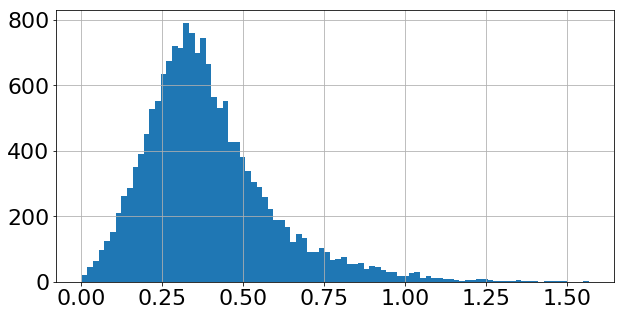

number of neurons for the layer 8: 8192


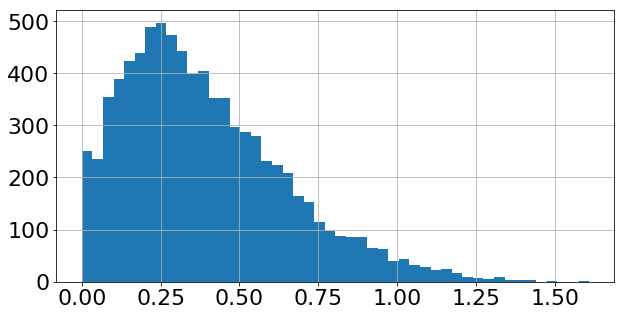

number of neurons for the layer 9: 8192


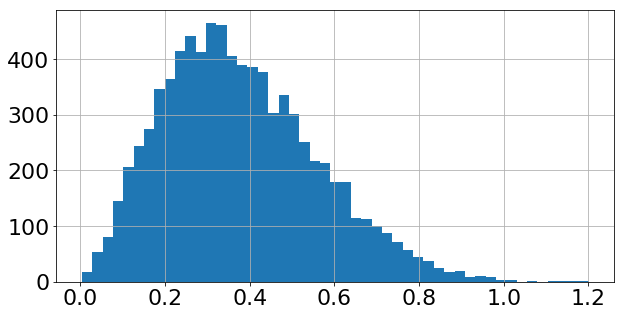

number of neurons for the layer 10: 8192


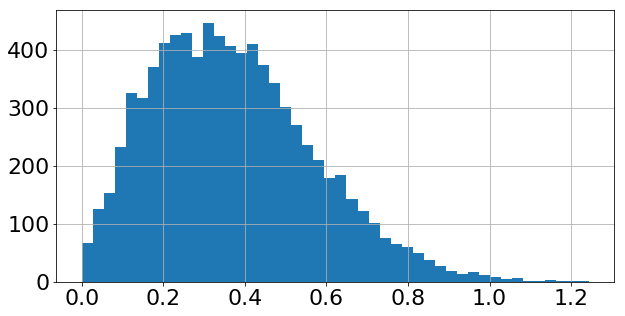

number of neurons for the layer 11: 2048


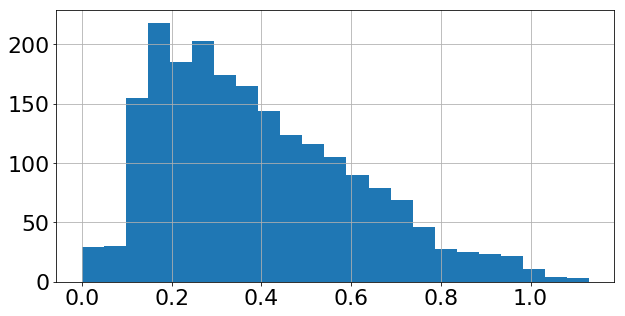

number of neurons for the layer 12: 2048


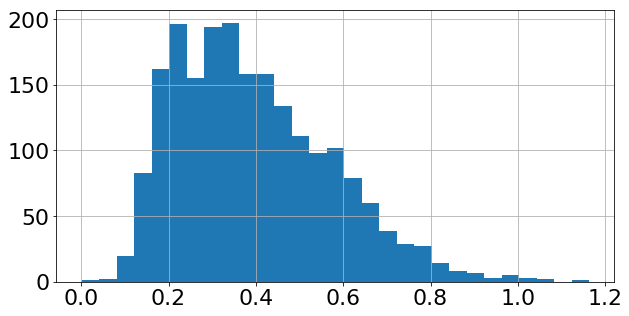

number of neurons for the layer 13: 2048


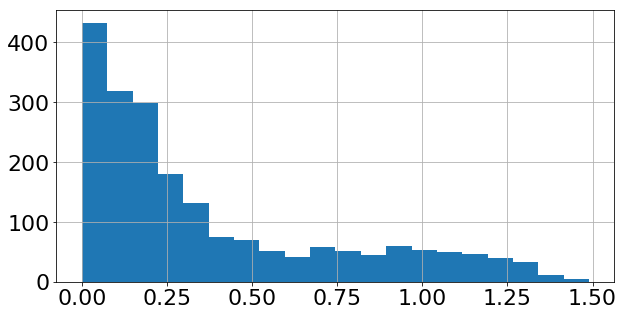

number of neurons for the layer 14: 512


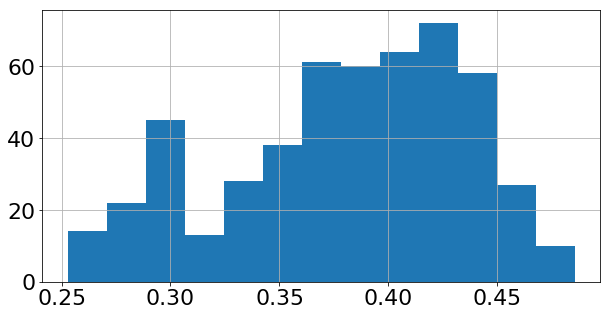

number of neurons for the layer 15: 10


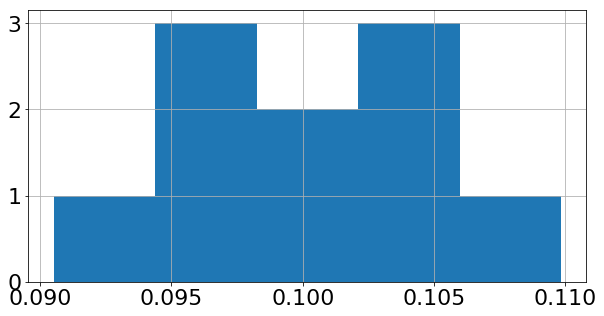

In [13]:
doss = 'Layca 2/'
modelename = 'vgg16_layca_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_sgd_0
number of neurons for the layer 1: 65536


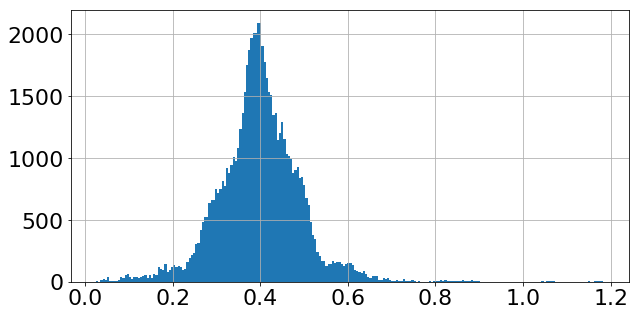

number of neurons for the layer 2: 65536


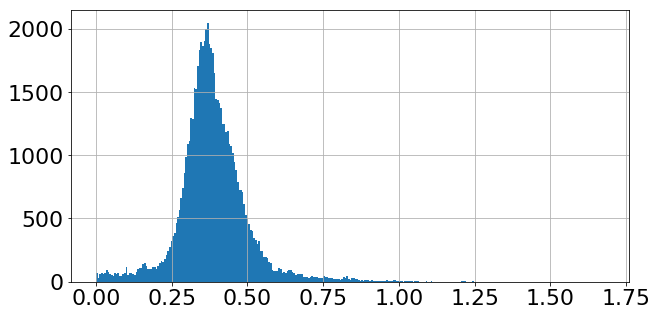

number of neurons for the layer 3: 32768


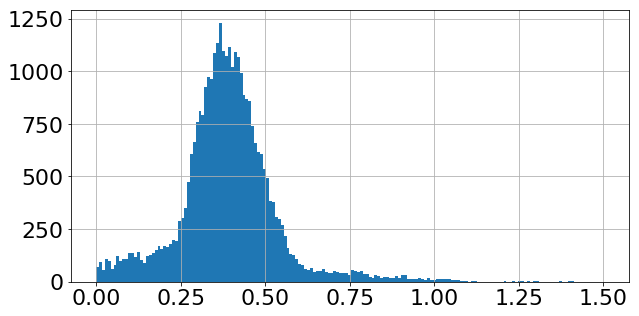

number of neurons for the layer 4: 32768


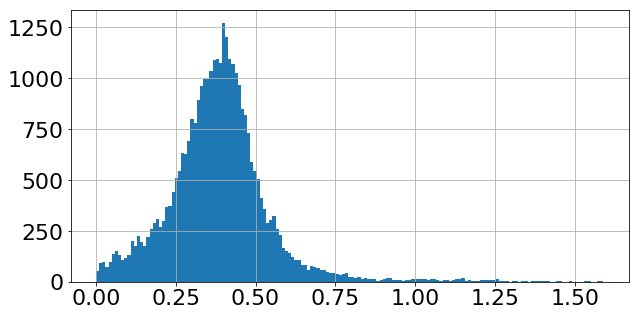

number of neurons for the layer 5: 16384


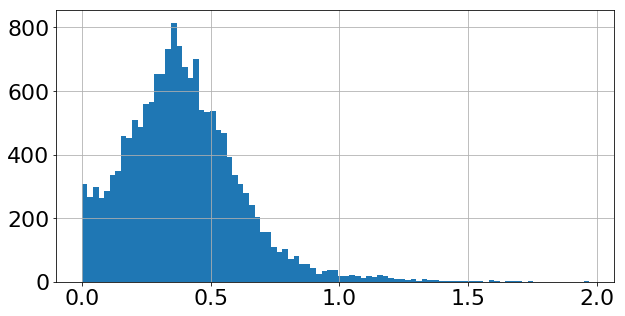

number of neurons for the layer 6: 16384


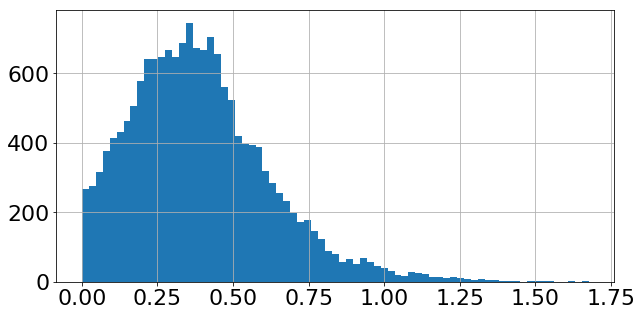

number of neurons for the layer 7: 16384


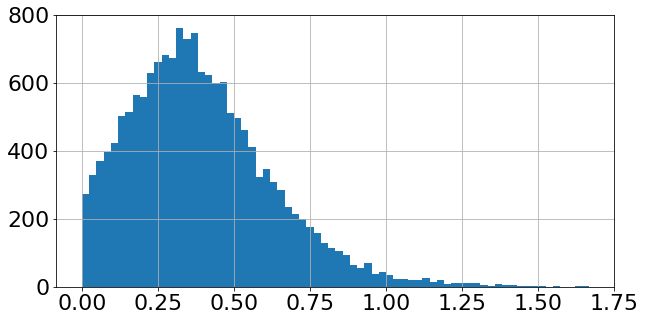

number of neurons for the layer 8: 8192


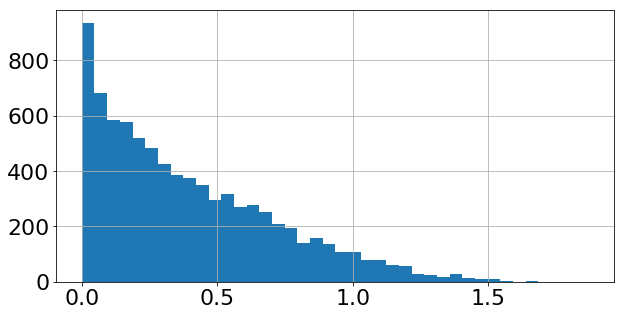

number of neurons for the layer 9: 8192


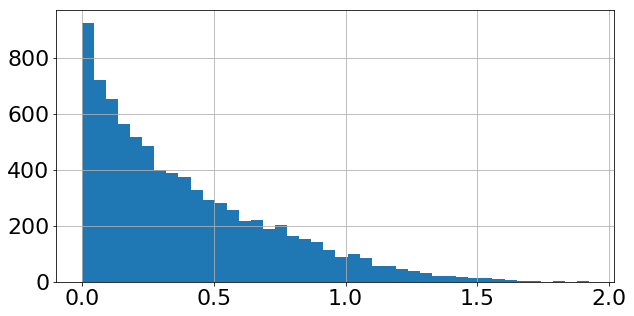

number of neurons for the layer 10: 8192


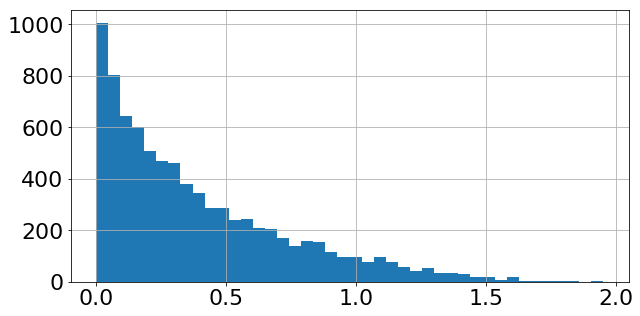

number of neurons for the layer 11: 2048


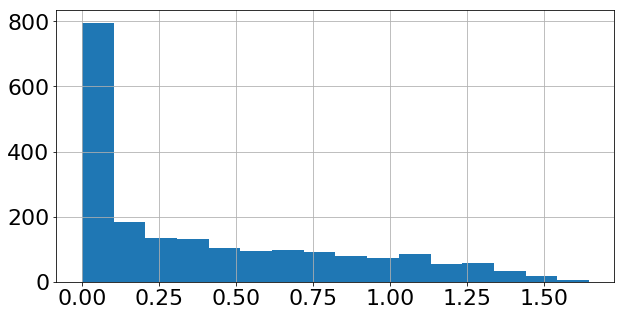

number of neurons for the layer 12: 2048


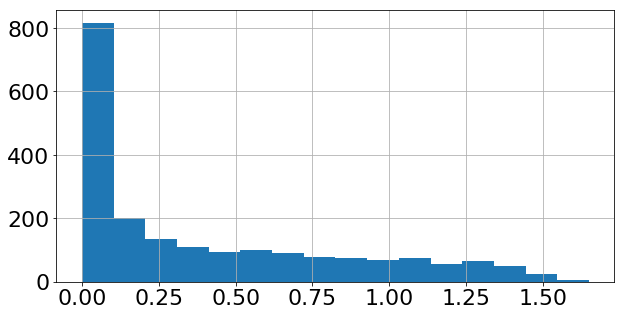

number of neurons for the layer 13: 2048


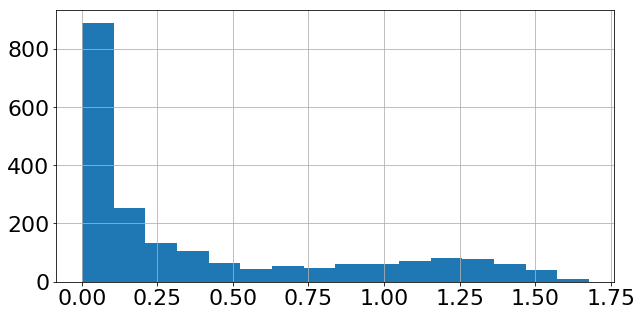

number of neurons for the layer 14: 512


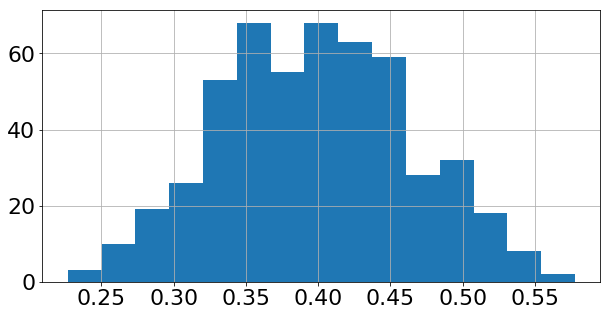

number of neurons for the layer 15: 10


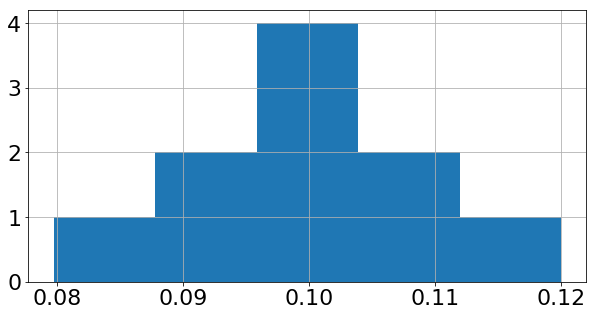

In [14]:
doss = 'SGD 0/'
modelename = 'vgg16_sgd_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_sgd_1
number of neurons for the layer 1: 65536


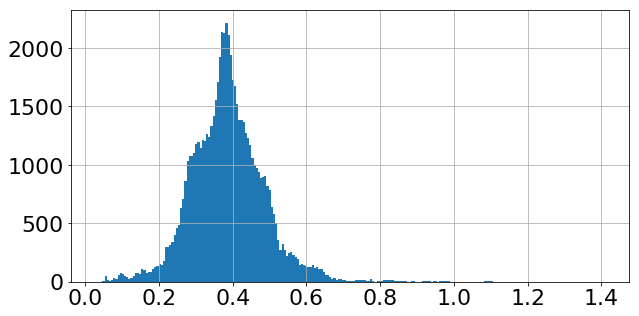

number of neurons for the layer 2: 65536


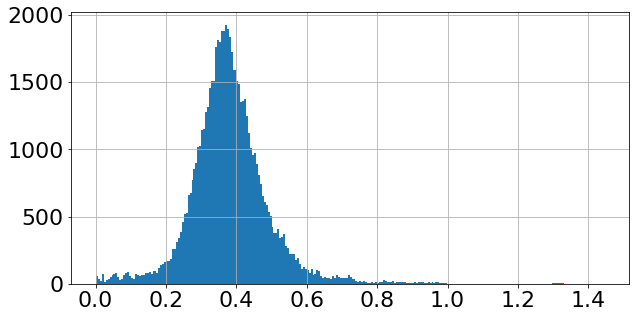

number of neurons for the layer 3: 32768


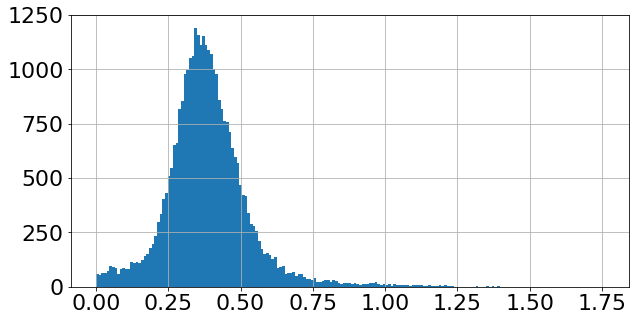

number of neurons for the layer 4: 32768


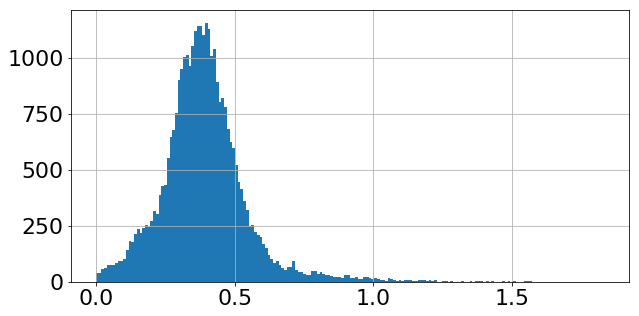

number of neurons for the layer 5: 16384


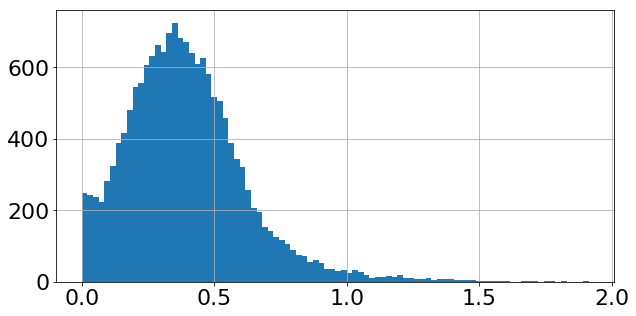

number of neurons for the layer 6: 16384


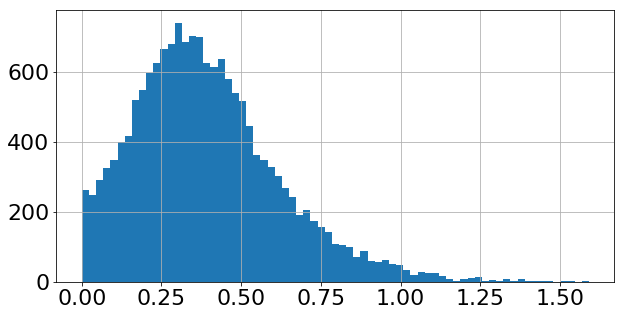

number of neurons for the layer 7: 16384


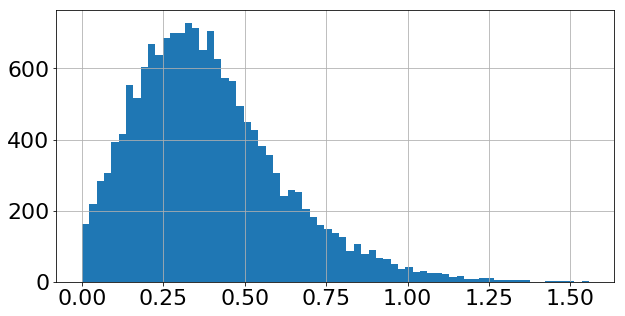

number of neurons for the layer 8: 8192


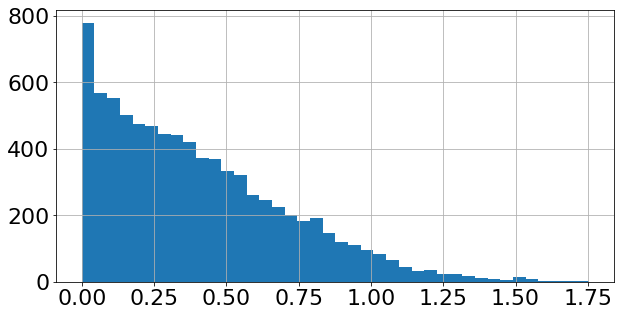

number of neurons for the layer 9: 8192


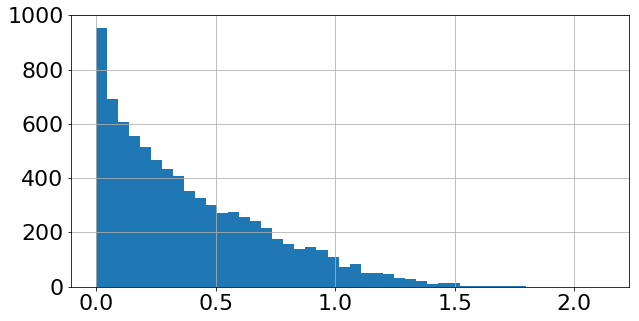

number of neurons for the layer 10: 8192


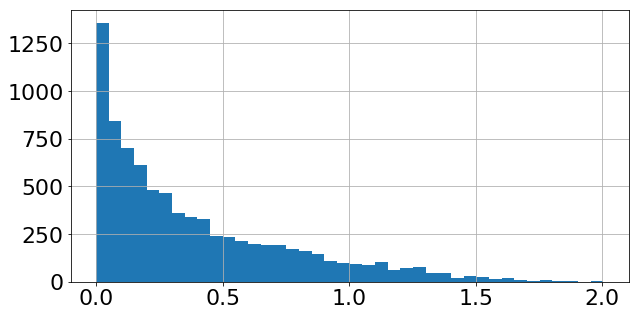

number of neurons for the layer 11: 2048


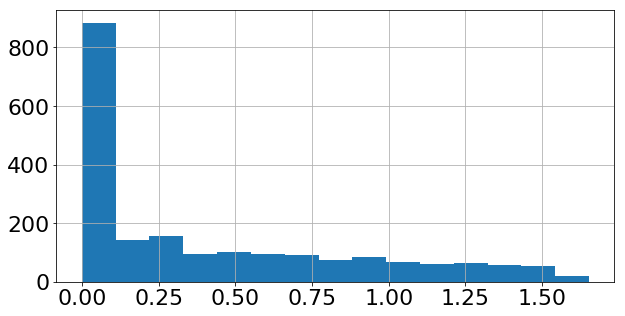

number of neurons for the layer 12: 2048


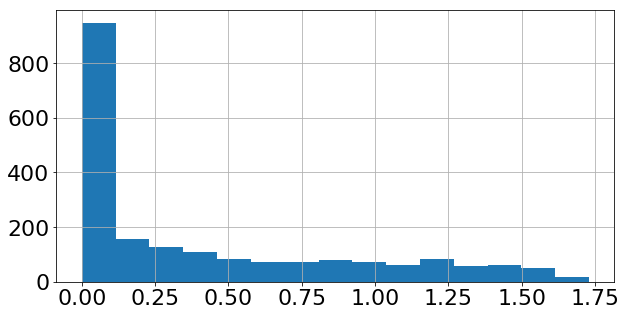

number of neurons for the layer 13: 2048


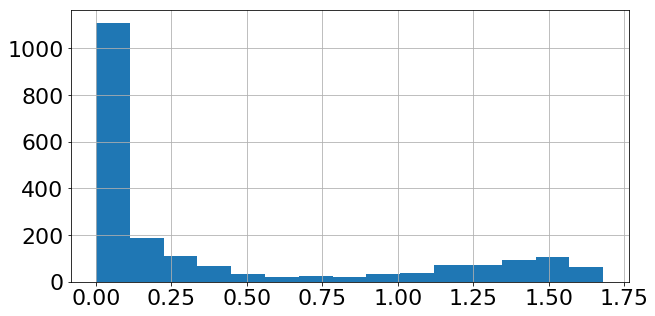

number of neurons for the layer 14: 512


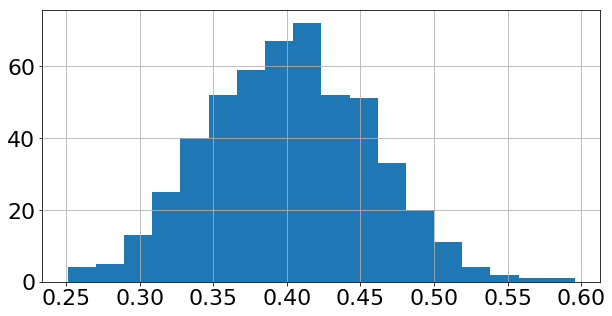

number of neurons for the layer 15: 10


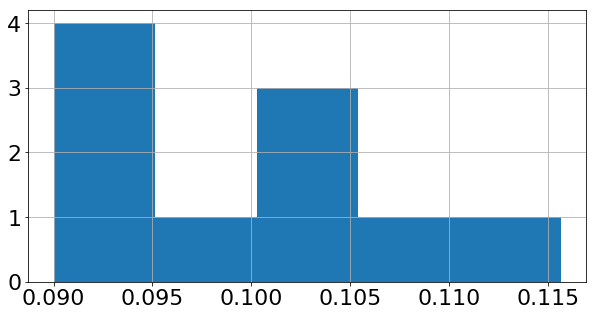

In [15]:
doss = 'SGD 1/'
modelename = 'vgg16_sgd_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_sgd_2
number of neurons for the layer 1: 65536


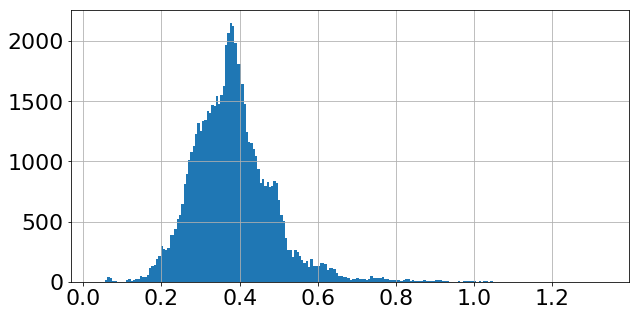

number of neurons for the layer 2: 65536


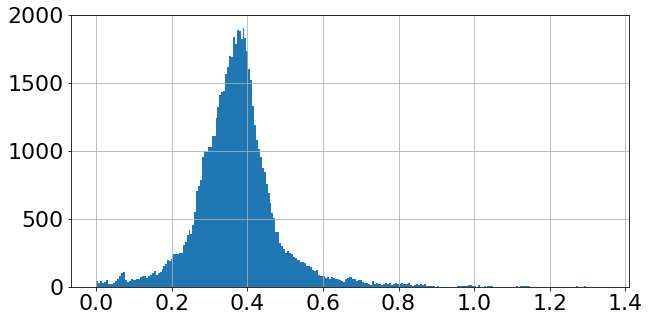

number of neurons for the layer 3: 32768


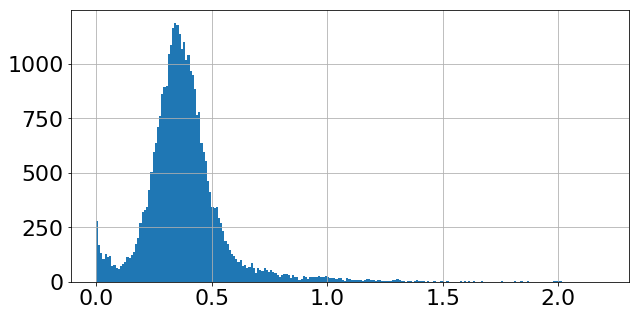

number of neurons for the layer 4: 32768


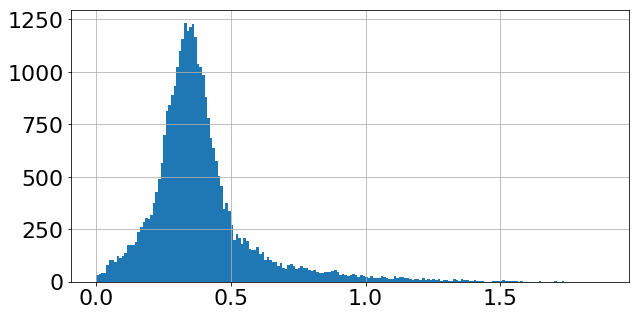

number of neurons for the layer 5: 16384


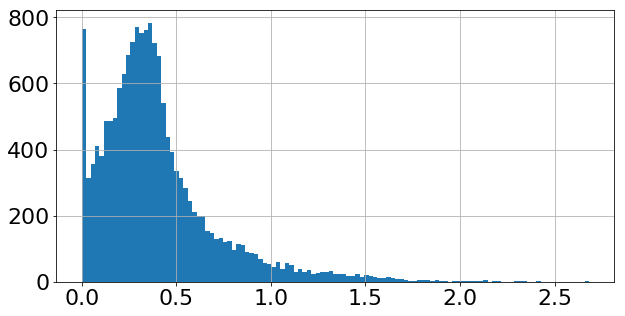

number of neurons for the layer 6: 16384


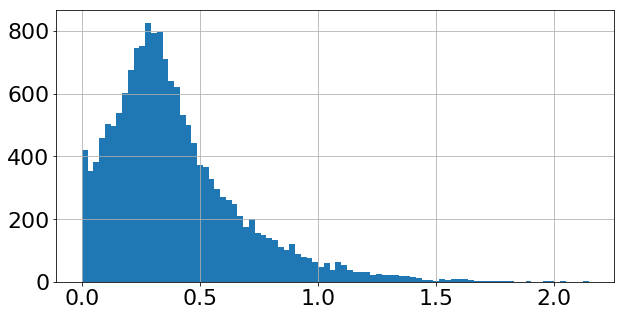

number of neurons for the layer 7: 16384


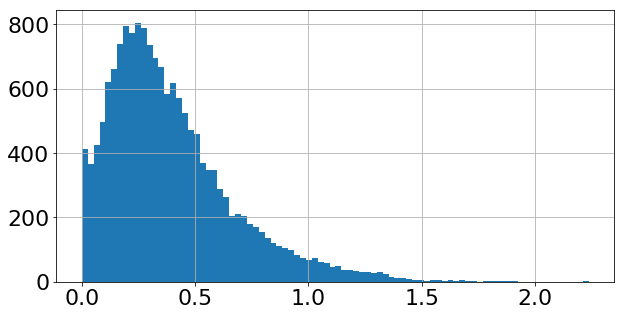

number of neurons for the layer 8: 8192


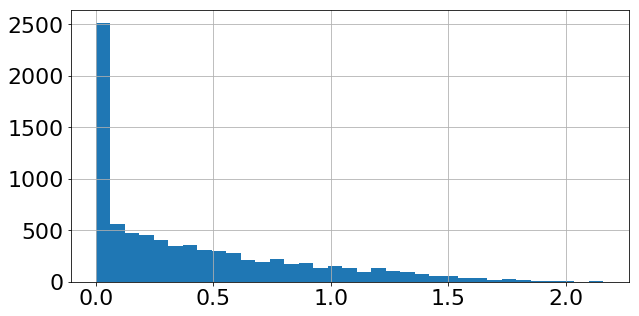

number of neurons for the layer 9: 8192


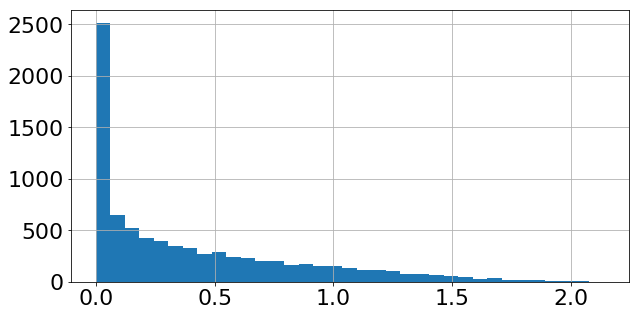

number of neurons for the layer 10: 8192


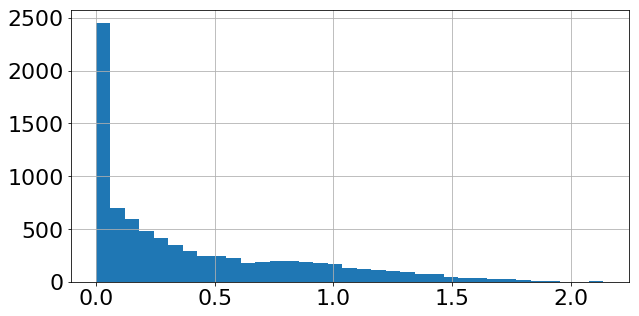

number of neurons for the layer 11: 2048


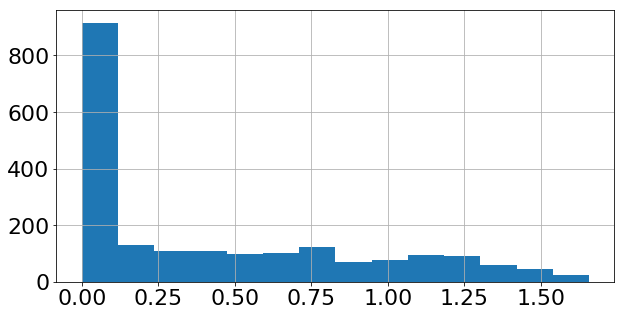

number of neurons for the layer 12: 2048


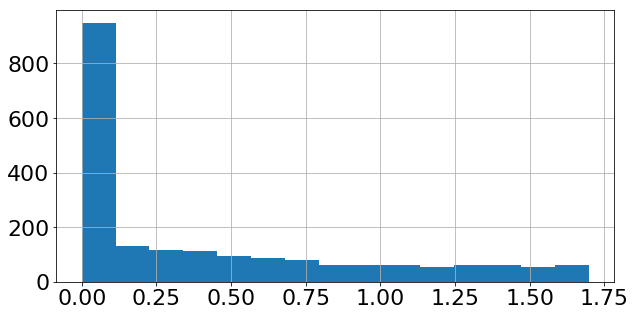

number of neurons for the layer 13: 2048


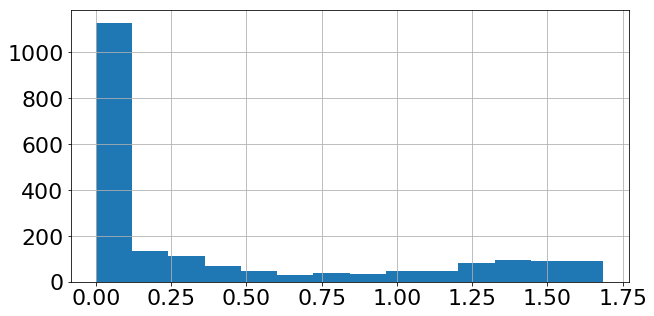

number of neurons for the layer 14: 512


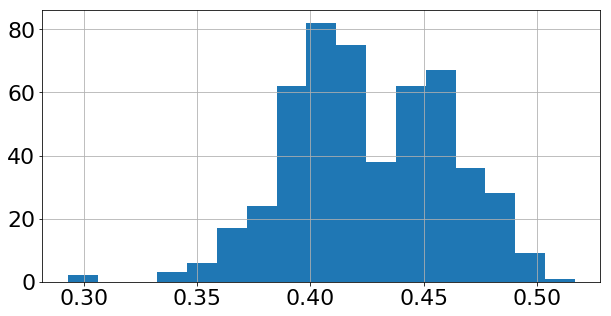

number of neurons for the layer 15: 10


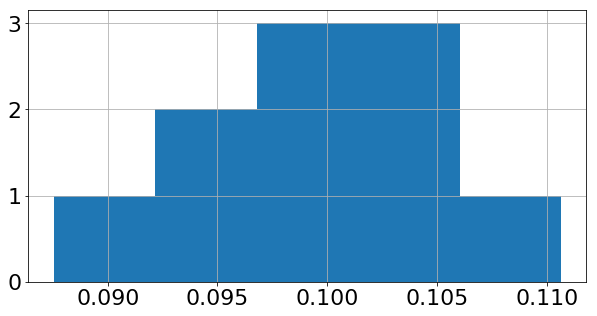

In [16]:
doss = 'SGD 2/'
modelename = 'vgg16_sgd_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_wdecay_0
number of neurons for the layer 1: 65536


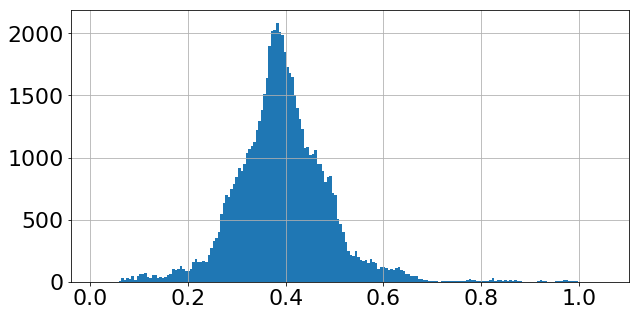

number of neurons for the layer 2: 65536


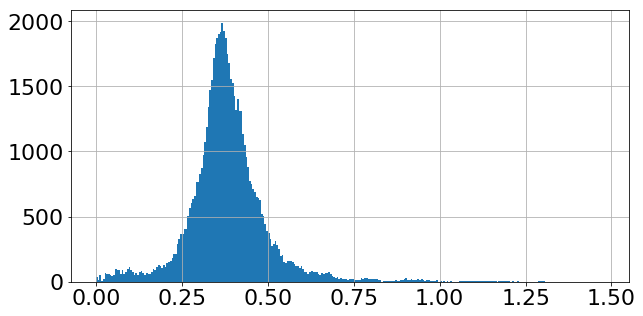

number of neurons for the layer 3: 32768


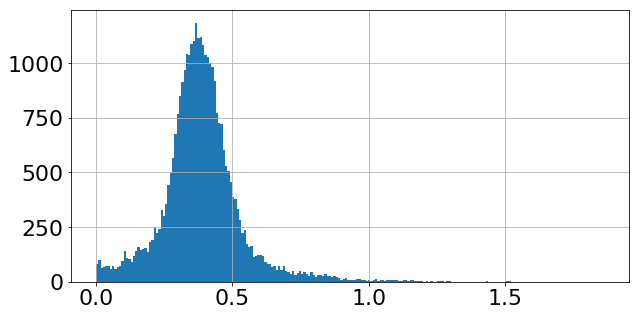

number of neurons for the layer 4: 32768


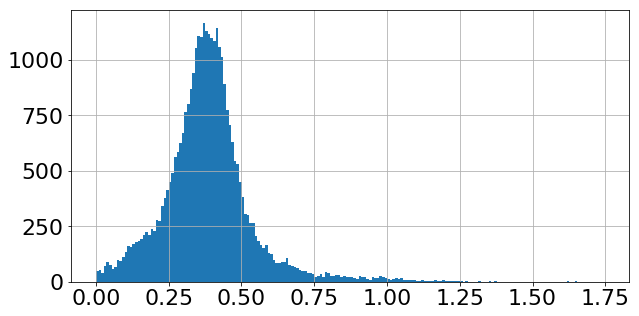

number of neurons for the layer 5: 16384


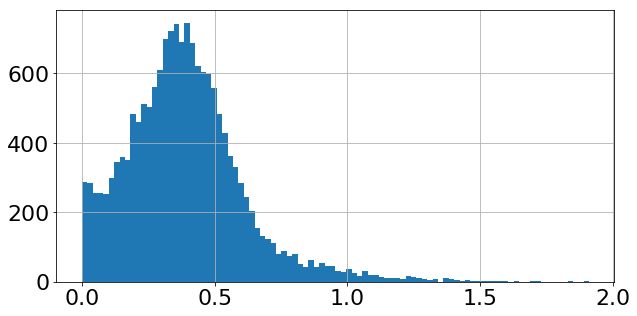

number of neurons for the layer 6: 16384


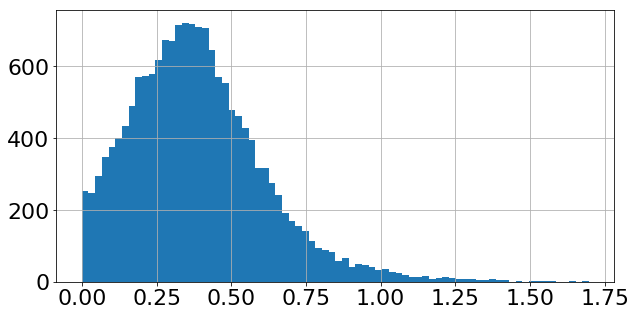

number of neurons for the layer 7: 16384


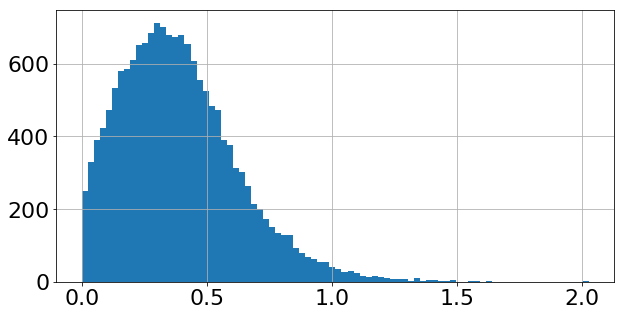

number of neurons for the layer 8: 8192


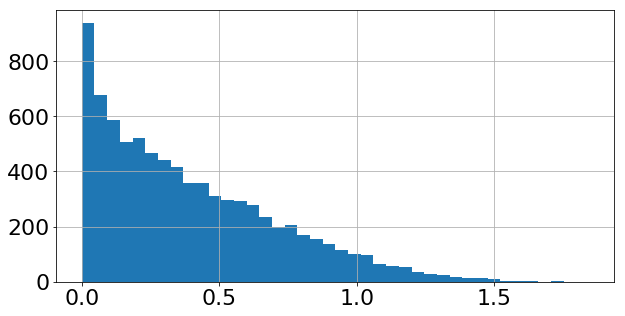

number of neurons for the layer 9: 8192


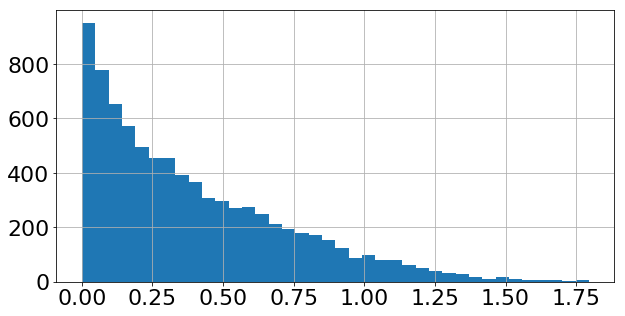

number of neurons for the layer 10: 8192


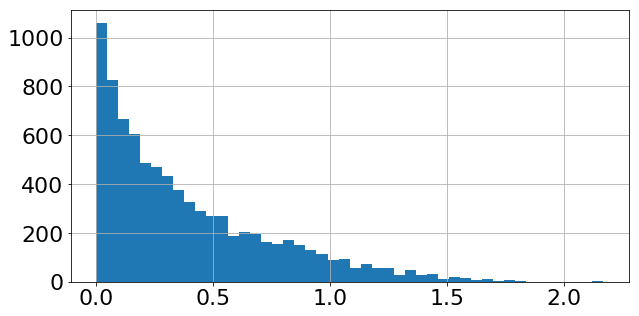

number of neurons for the layer 11: 2048


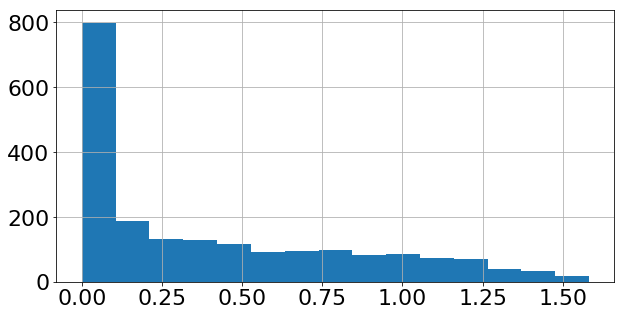

number of neurons for the layer 12: 2048


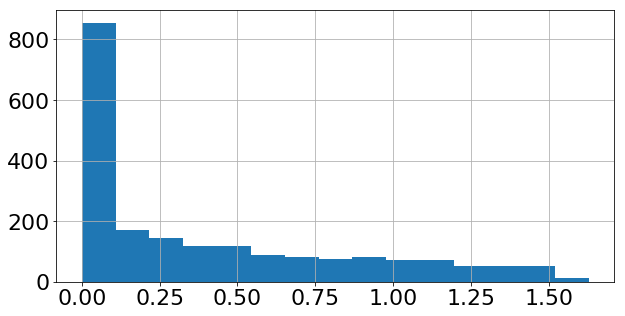

number of neurons for the layer 13: 2048


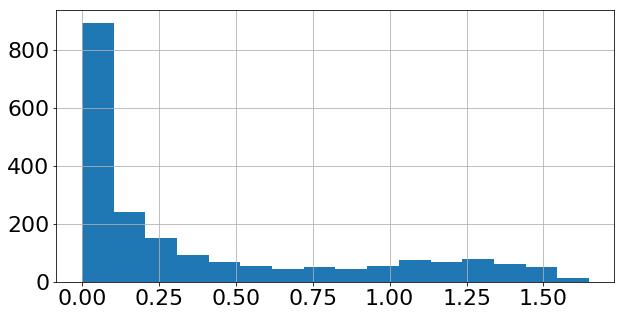

number of neurons for the layer 14: 512


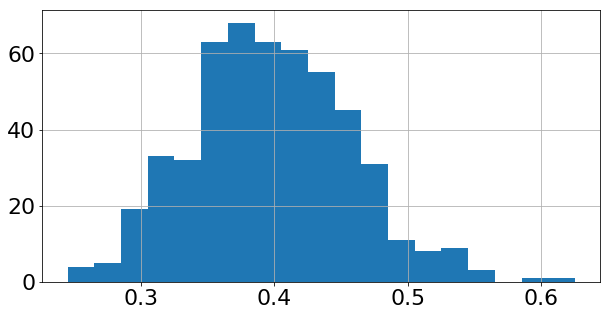

number of neurons for the layer 15: 10


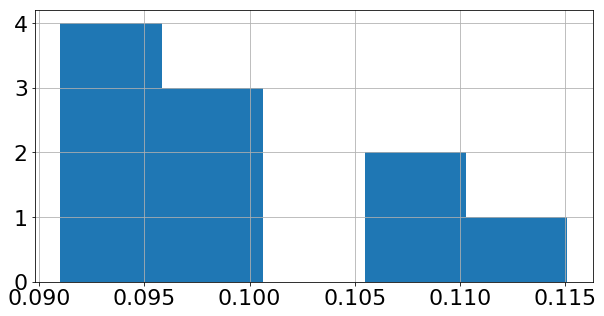

In [17]:
doss = 'Weight Decay 0/'
modelename = 'vgg16_wdecay_0'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_wdecay_1
number of neurons for the layer 1: 65536


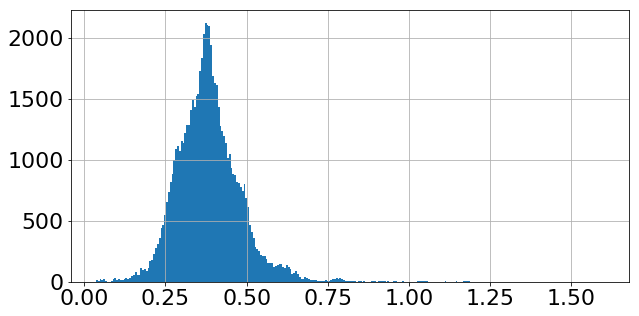

number of neurons for the layer 2: 65536


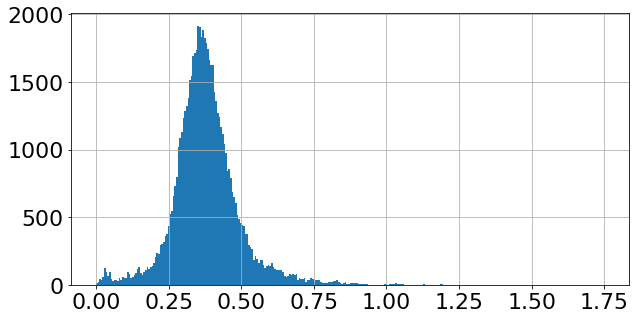

number of neurons for the layer 3: 32768


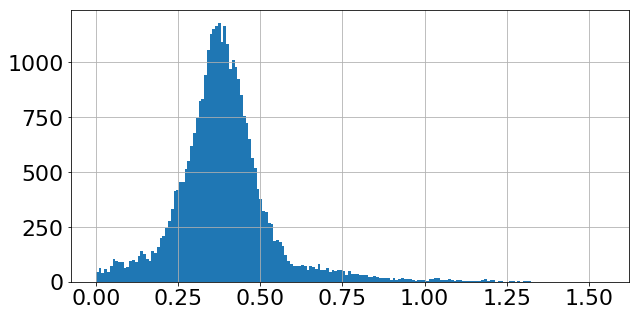

number of neurons for the layer 4: 32768


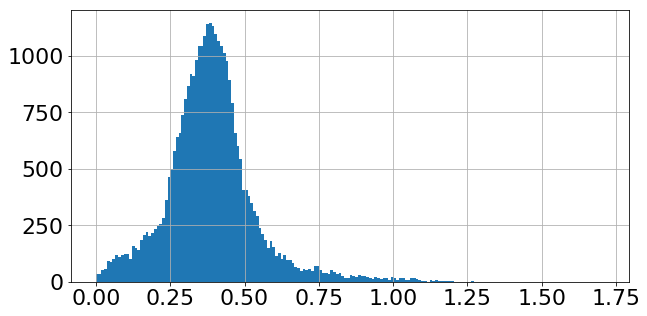

number of neurons for the layer 5: 16384


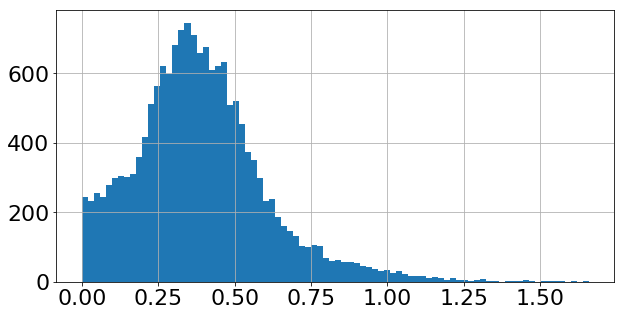

number of neurons for the layer 6: 16384


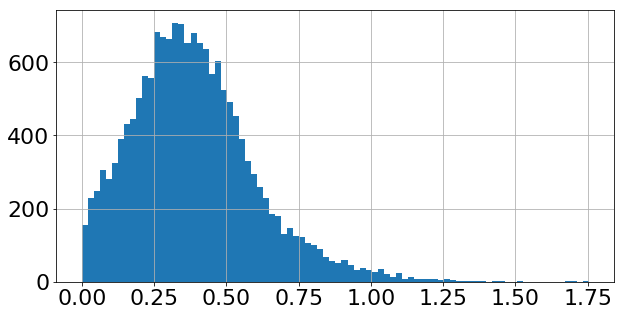

number of neurons for the layer 7: 16384


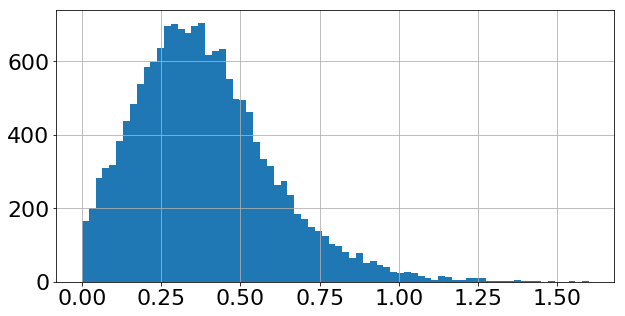

number of neurons for the layer 8: 8192


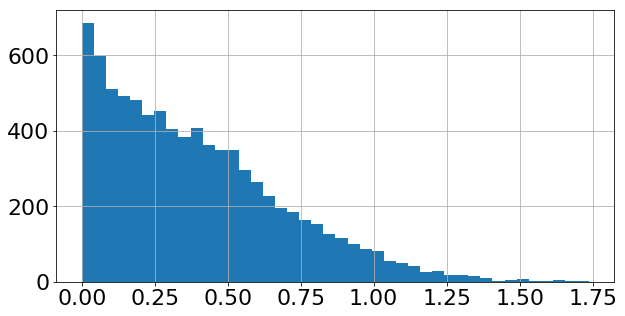

number of neurons for the layer 9: 8192


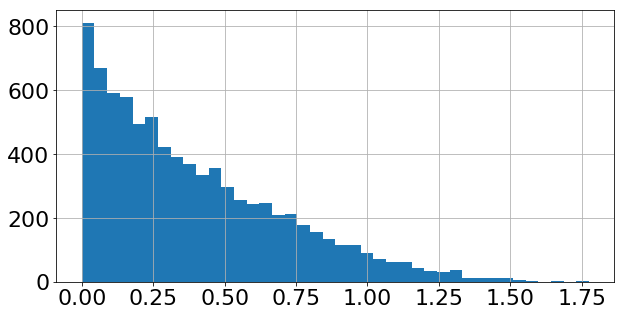

number of neurons for the layer 10: 8192


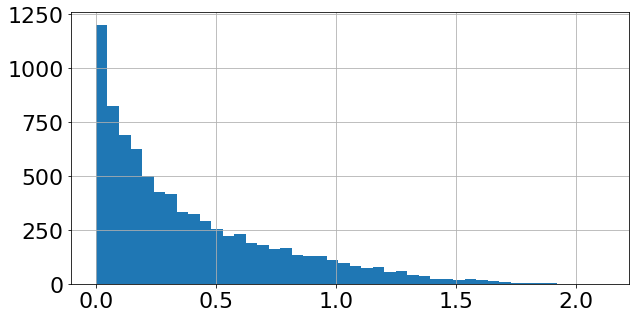

number of neurons for the layer 11: 2048


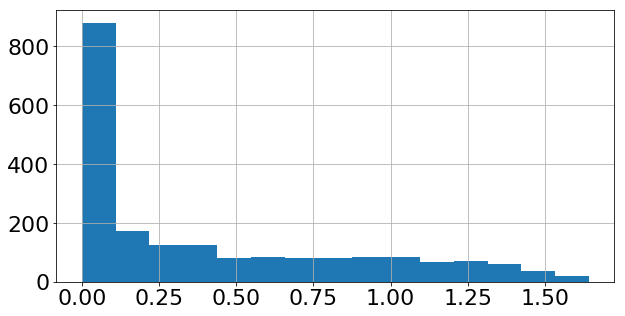

number of neurons for the layer 12: 2048


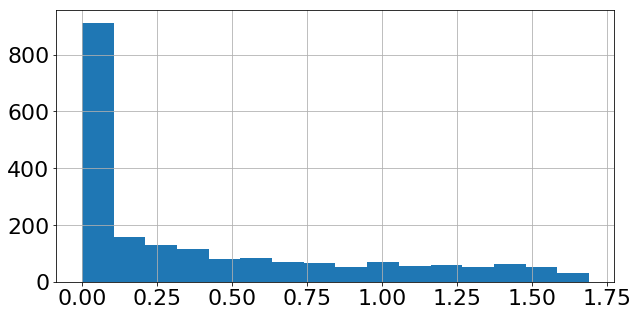

number of neurons for the layer 13: 2048


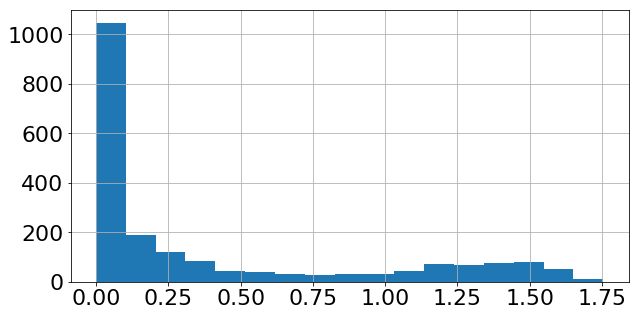

number of neurons for the layer 14: 512


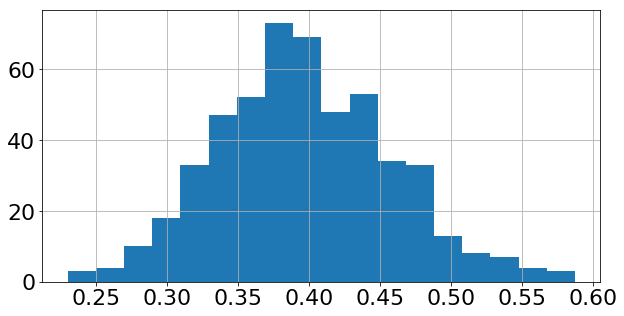

number of neurons for the layer 15: 10


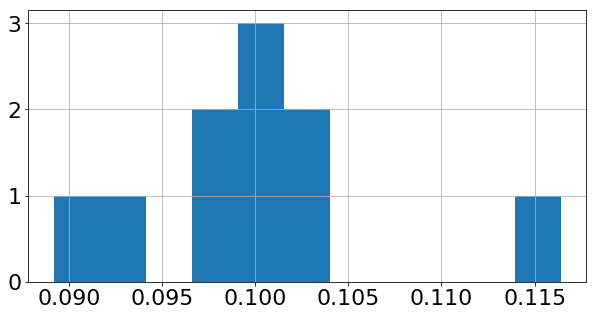

In [18]:
doss = 'Weight Decay 1/'
modelename = 'vgg16_wdecay_1'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)

modelename: vgg16_wdecay_2
number of neurons for the layer 1: 65536


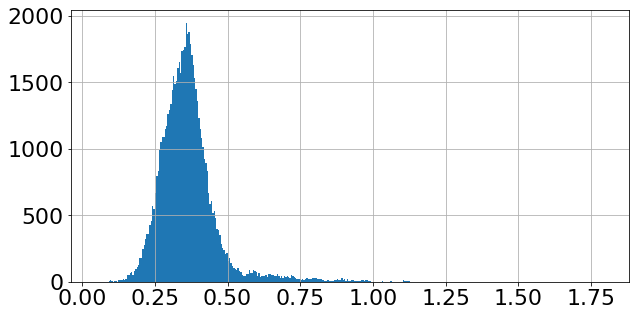

number of neurons for the layer 2: 65536


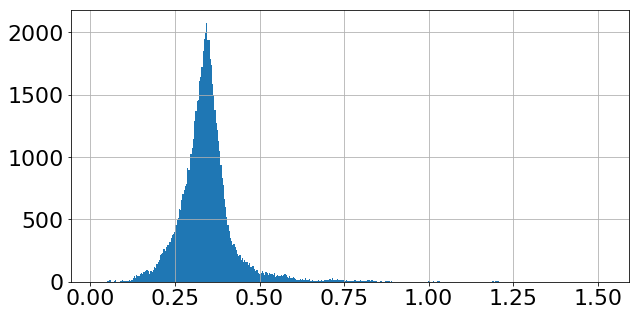

number of neurons for the layer 3: 32768


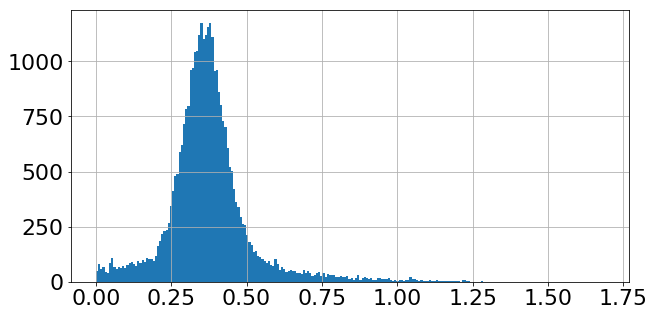

number of neurons for the layer 4: 32768


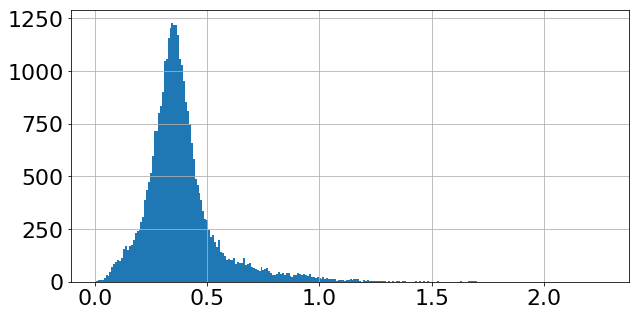

number of neurons for the layer 5: 16384


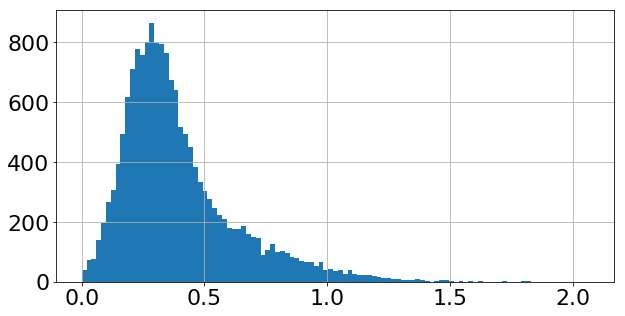

number of neurons for the layer 6: 16384


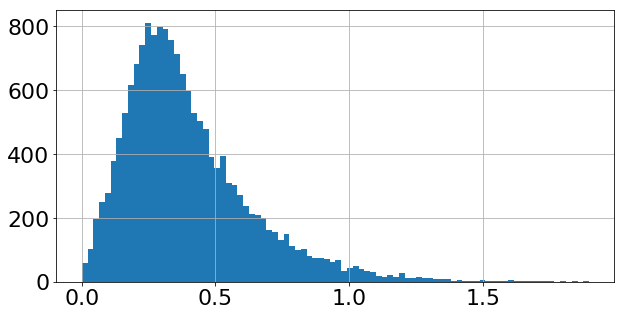

number of neurons for the layer 7: 16384


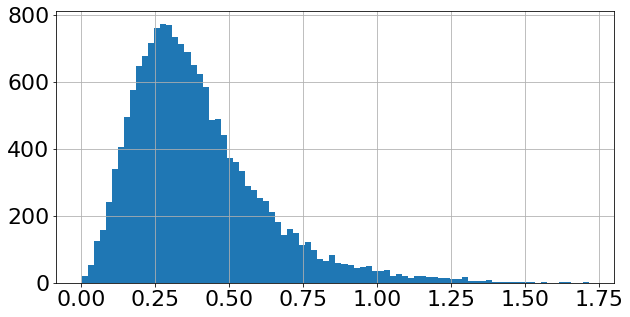

number of neurons for the layer 8: 8192


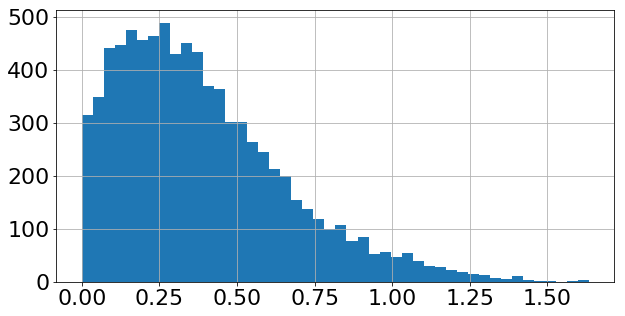

number of neurons for the layer 9: 8192


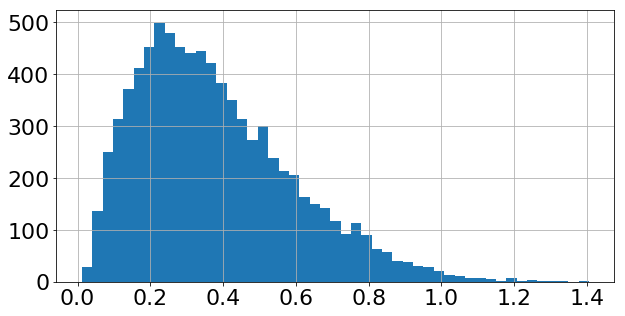

number of neurons for the layer 10: 8192


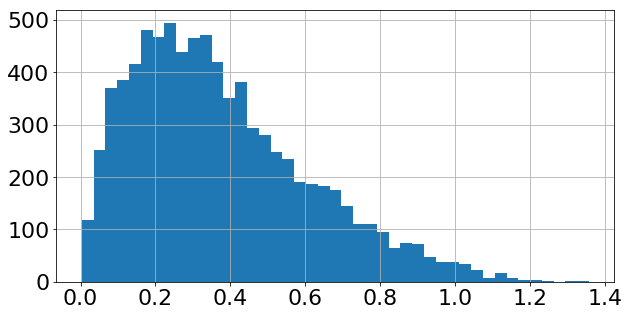

number of neurons for the layer 11: 2048


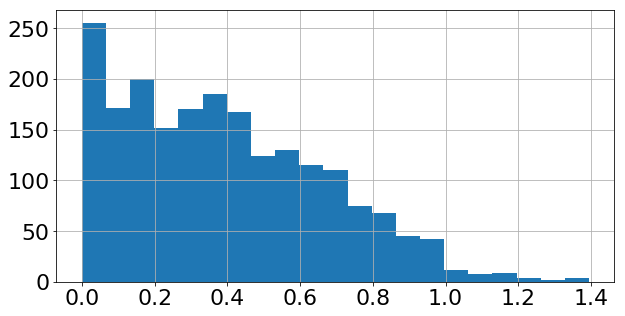

number of neurons for the layer 12: 2048


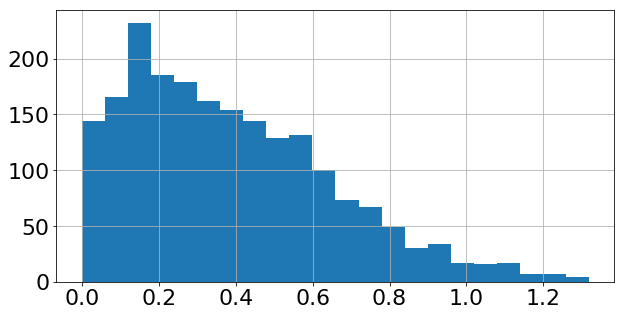

number of neurons for the layer 13: 2048


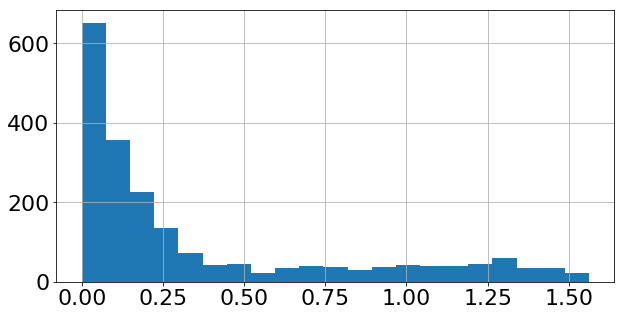

number of neurons for the layer 14: 512


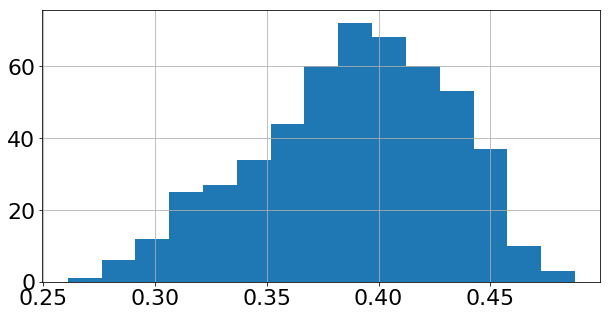

number of neurons for the layer 15: 10


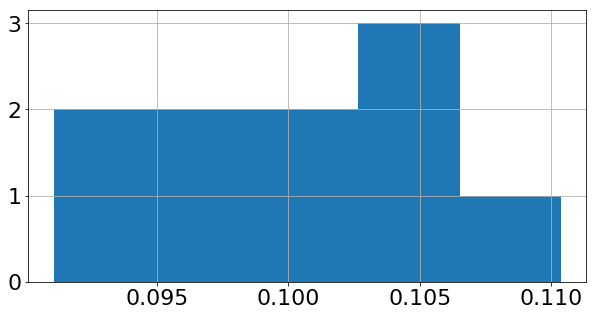

In [19]:
doss = 'Weight Decay 2/'
modelename = 'vgg16_wdecay_2'
model_name = '../weights/6/{}/final/weights-final.hdf5'.format(modelename)
model.load_weights('{}'.format(model_name))
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
IM = get_activations(model, Echantillon)
# Run the code
RUN(IM, modelename, doss)